# Telecom Churn Case Study

## Business Problem Overview

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of `15-25% annual churn rate`. It costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention is even more important than customer acquisition. 

## Business Objective

To `reduce customer churn`, telecom companies need to predict which customers are at high risk of churn. The business objective is to predict the churn for prepaid customers in the last (i.e. the ninth) month using the data (features) from the first three months.

### Customer behaviour during churn

Following customer behaviour is the basis of churn detection strategy.

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, following three phases of customer lifecycle are considered

<font color='green'>**The ‘good’ phase**:</font> In this phase, the customer is happy with the service and behaves as usual.

<font color='orange'>**The ‘action’ phase**:</font> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

<font color='red'>**The ‘churn’ phase**:</font> In this phase, the customer is said to have churned. Churn is defined based on this phase.

### Churn detection strategy

***High-value Churn*** : In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus with reduction of high-value customers churn, business will be able to reduce significant revenue leakage.

***Usage-based churn***: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time are termed as churned customers


In [1]:
##Importing all the required libraris
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime

##SKLearn libraries
from sklearn import model_selection, preprocessing,metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split,KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score,roc_auc_score,classification_report,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


#XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

##To do resampling for class imbalance
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.metrics import sensitivity_specificity_support

In [2]:
# set the display parameters to show more rows and columns
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500)

# **<font color='blue'>1. Data Understanding & Pre-processing</font>**

In [3]:
# read the telecom customer data to dataframe
telecom = pd.read_csv('telecom_churn_data.csv') 

In [4]:
telecom.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [5]:
print('There are {} rows and {} columns.'.format(*telecom.shape))

There are 99999 rows and 226 columns.


## 1.1 Filter high-value customers:
- high-value customers: Those who have recharged with an amount more than or equal to X, where X is the `70th percentile` of the `average recharge amount` in the first two months (the good phase).
- After filtering the high-value customers, we should get about 29.9k rows.

**Assumption:**
- We need to take 70th percentile of average of `total_rech_amt_6`+`total_rech_amt_7` to find High value customers

In [6]:
#Calculate the 70th percentile of average(month_6 and month_7) total recharge amount 
quantile_70 = pd.DataFrame((telecom['total_rech_amt_6'] + telecom['total_rech_amt_7'])/2).quantile(0.7)[0]
print("70th Percentile of average total recharge amount is:", quantile_70)

#Filter high value customers with avaerage recharge amount greater than or equal to 70th percentille
HV_telecom = telecom.loc[(telecom['total_rech_amt_6'] + telecom['total_rech_amt_7'])/2 >= quantile_70]
print('There are {} rows and {} columns after filtering the dataset with HV customers.'.format(*HV_telecom.shape))

#Checking total revenue being generated by High value customers###
print("Total revenue generated by high value customers (based on call rech amount) %:",
                  round((sum(HV_telecom['total_rech_amt_6']+HV_telecom['total_rech_amt_7'] + HV_telecom['total_rech_amt_8']))/
                        (sum(telecom['total_rech_amt_6']+telecom['total_rech_amt_7'] + telecom['total_rech_amt_8']))*100,2))

print("Total revenue generated by high value customers (based on arpu amount) %:",
                  round((sum(HV_telecom['arpu_6']+HV_telecom['arpu_7'] + HV_telecom['arpu_8']))/
                        (sum(telecom['arpu_6']+telecom['arpu_7'] + telecom['arpu_8']))*100,2))

70th Percentile of average total recharge amount is: 368.5
There are 30011 rows and 226 columns after filtering the dataset with HV customers.
Total revenue generated by high value customers (based on call rech amount) %: 61.8
Total revenue generated by high value customers (based on arpu amount) %: 61.09


## 1.2 Tag churners:

To tag the churned customers (`churn=1, else 0`) use the fourth month of data as follows: 

1. Those who have not made any calls (either incoming or outgoing) AND 
2. Have not used mobile internet even once in the churn phase. 

The attributes used to tag churners are: `total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9`

In [7]:
#Let us assign '1' to the customers having no usage (as per above condition) in 9th month
HV_telecom.loc[((HV_telecom['total_ic_mou_9']== 0) & (HV_telecom['total_og_mou_9']== 0)) & 
                (HV_telecom['vol_2g_mb_9']   == 0) & (HV_telecom['vol_3g_mb_9']   == 0),'churn'] = 1

#Let us assign '0' to the remaining customers 
HV_telecom['churn'].fillna(0,inplace=True)

print("The churn ratio looks like: ",round(HV_telecom['churn'].value_counts()[1]/HV_telecom['churn'].count()*100,2))

The churn ratio looks like:  8.64


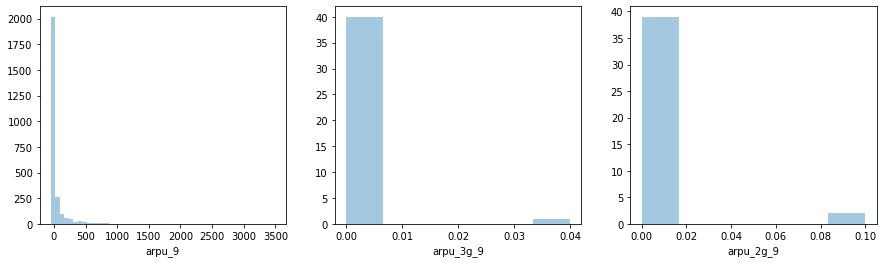

In [8]:
#Let us also verify the following attributes -`arpu`, `arpu_3g_9` and `arpu_2g_9` values for churned customers
HV_telecom_9 = HV_telecom[['churn','arpu_9','arpu_3g_9','arpu_2g_9']]
HV_telecom_9 = HV_telecom_9.loc[(HV_telecom_9['churn'] == 1)]

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.distplot(HV_telecom_9['arpu_9'].dropna(),kde=False)
plt.subplot(1,3,2)
sns.distplot(HV_telecom_9['arpu_3g_9'].dropna(),kde=False)
plt.subplot(1,3,3)
sns.distplot(HV_telecom_9['arpu_2g_9'].dropna(),kde=False)
plt.show()

**Observations:**
- The value for all the attributes are '0' which is expected.

## 1.3 Remove all the attributes of the churn phase
- Remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names)

In [9]:
columns_9 = [col for col in HV_telecom.columns if ('_9' in col)]
columns_9.append('sep_vbc_3g')  ## Adding it seprately as it doesn't have _9
HV_telecom.drop(columns=columns_9,inplace=True)
print('There are {} rows and {} columns after dropping all the attributes of churn phase.'.format(*HV_telecom.shape))

There are 30011 rows and 172 columns after dropping all the attributes of churn phase.


### 1.4 Checking Missing Values

In [10]:
#Checking percentage of missing values in each column
percent_missing = round((((HV_telecom.isnull() | HV_telecom.isna()).sum()/HV_telecom.shape[0])*100).sort_values(ascending=False),2)
percent_missing.head(20)

arpu_3g_6                   62.02
av_rech_amt_data_6          62.02
max_rech_data_6             62.02
fb_user_6                   62.02
count_rech_2g_6             62.02
date_of_last_rech_data_6    62.02
night_pck_user_6            62.02
count_rech_3g_6             62.02
arpu_2g_6                   62.02
total_rech_data_6           62.02
av_rech_amt_data_7          61.14
night_pck_user_7            61.14
count_rech_3g_7             61.14
total_rech_data_7           61.14
arpu_2g_7                   61.14
count_rech_2g_7             61.14
date_of_last_rech_data_7    61.14
max_rech_data_7             61.14
fb_user_7                   61.14
arpu_3g_7                   61.14
dtype: float64

**Observations:**
- Based on missing values, it seems there are huge set of customers who are not using below features and hence data is not available for their related columns:
1. **2g or 3g data** (i.e.: arpu_3g_6/7/8, count_rech_3g_6/7/8, arpu_2g_6/7/8, count_rech_2g_6/7/8, max_rech_data_6/7/8, total_rech_data_6/7/8, date_of_last_rech_data_6/7/8 etc...)
2. **fb** (fb_user_6/7/8)
3. **Night pack** (night_pck_user_6/7/8)

# **<font color='blue'>2. Data Cleansing</font>**

### 2.1 Checking Unique Values across columns

In [11]:
#Lets us now check which features will have very little significance in the final model.
#Rational for this task is to identify columns which have more than 90% of 1 type of value
uni_val = pd.DataFrame(HV_telecom.nunique().sort_values(ascending=True)).reset_index()
uni_val.columns = ['column_name','unique_values']

categorical_featurelist = uni_val.loc[uni_val['unique_values']<20]['column_name'].to_list()

In [12]:
for f in categorical_featurelist:
    print(100*HV_telecom[f].value_counts(normalize=True,dropna=False))
    print('\n') 

0.0    98.947053
NaN     1.052947
Name: std_ic_t2o_mou_6, dtype: float64


109    100.0
Name: circle_id, dtype: float64


0.0    99.620139
NaN     0.379861
Name: loc_og_t2o_mou, dtype: float64


0.0    99.620139
NaN     0.379861
Name: std_og_t2o_mou, dtype: float64


0.0    99.620139
NaN     0.379861
Name: loc_ic_t2o_mou, dtype: float64


6/30/2014    100.0
Name: last_date_of_month_6, dtype: float64


7/31/2014    99.896705
NaN           0.103295
Name: last_date_of_month_7, dtype: float64


8/31/2014    99.476858
NaN           0.523142
Name: last_date_of_month_8, dtype: float64


0.0    96.874479
NaN     3.125521
Name: std_ic_t2o_mou_8, dtype: float64


0.0    96.874479
NaN     3.125521
Name: std_og_t2c_mou_8, dtype: float64


0.0    98.99037
NaN     1.00963
Name: std_og_t2c_mou_7, dtype: float64


0.0    98.947053
NaN     1.052947
Name: std_og_t2c_mou_6, dtype: float64


0.0    98.99037
NaN     1.00963
Name: std_ic_t2o_mou_7, dtype: float64


NaN    62.023925
0.0    36.939789
1.0     

**Observations:**
- Below variables doesnt have significant variance in data and would not necessarily add any value to the model:
  - 'std_ic_t2o_mou_6', 'std_og_t2c_mou_8','std_ic_t2o_mou_7','std_ic_t2o_mou_8',
  - 'std_og_t2c_mou_7', 'last_date_of_month_8', 'std_og_t2c_mou_6','last_date_of_month_6',
  - 'loc_ic_t2o_mou','std_og_t2o_mou','loc_og_t2o_mou','circle_id','last_date_of_month_7'

In [13]:
#Lets drop the avobe columns
cols_to_drop = ['std_ic_t2o_mou_6', 'std_og_t2c_mou_6','std_ic_t2o_mou_7','std_og_t2c_mou_7',
                'std_ic_t2o_mou_8','std_og_t2c_mou_8','std_og_t2o_mou',
                'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',
                'loc_ic_t2o_mou','loc_og_t2o_mou','circle_id','mobile_number']

HV_telecom.drop(columns=cols_to_drop,inplace=True)
print('There are {} rows and {} columns left after initial feature selection.'.format(*HV_telecom.shape))

There are 30011 rows and 158 columns left after initial feature selection.


In [14]:
#Rename below columns for consistency purpose
HV_telecom.rename(columns = {'jun_vbc_3g':'vbc_3g_6',
                             'jul_vbc_3g':'vbc_3g_7',
                             'aug_vbc_3g':'vbc_3g_8',}, inplace=True)

### 2.2 Treating Missing Values

- We will impute numerical values with 0 for Numerical columns
- We will also impute -1 as new category for Categorical columns (and will drop this new category during Dummy creation)

In [15]:
# Nan actually means users not using night pack
night_pck_cols = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']
HV_telecom[night_pck_cols] = HV_telecom[night_pck_cols].fillna(value=0, axis=1) 

#Nan actually means users not using fb 
fb_user_cols = ['fb_user_6', 'fb_user_7', 'fb_user_8']
HV_telecom[fb_user_cols] = HV_telecom[fb_user_cols].fillna(value=0, axis=1) 

#No nan's present in monthly_2g/3g
monthly_2g_3g_cols = ['monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8']

columns_cat = night_pck_cols + fb_user_cols + monthly_2g_3g_cols

In [16]:
#Let us segregate features for the month of June, July and August
columns_6 = [col for col in HV_telecom.columns if ('6' in col and 'date' not in col and col not in columns_cat)]
columns_7 = [col for col in HV_telecom.columns if ('7' in col and 'date' not in col and col not in columns_cat)]
columns_8 = [col for col in HV_telecom.columns if ('8' in col and 'date' not in col and col not in columns_cat)]

# Imputing nan for continous features
HV_telecom[columns_6] = HV_telecom[columns_6].fillna(0)
HV_telecom[columns_7] = HV_telecom[columns_7].fillna(0)
HV_telecom[columns_8] = HV_telecom[columns_8].fillna(0)

columns_cat_new = ['night_pck_user','fb_user','monthly_2g','monthly_3g']

### 2.3 Outlier Treatment

In [17]:
#Let us first see the outliers
HV_telecom.describe([0.5,0.75,0.95,0.99,0.995,0.998])

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  30011.000000  30011.000000  30011.000000  30011.000000  30011.000000   
mean     587.284404    589.135427    534.857433    296.034461    304.343206   
std      442.722413    462.897814    492.259586    460.775592    481.780488   
min    -2258.709000  -2014.045000   -945.808000      0.000000      0.000000   
50%      495.682000    493.561000    452.091000    125.830000    125.460000   
75%      703.922000    700.788000    671.150000    353.310000    359.925000   
95%     1240.793500   1261.421500   1258.555500   1153.970000   1208.175000   
99%     1983.089500   1999.374500   1987.934400   2166.370000   2220.367000   
99.5%   2415.171300   2387.016500   2410.032600   2732.489000   2782.400000   
99.8%   3119.681580   3211.195680   3193.806560   3425.028400   3644.324600   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  30011.000000  30011.000000  30011.000000  30011.000000   30011.000000   
mean     267.600412    417.933372    423.924375    375.021691      17.412764   
std      466.560947    470.588583    486.525332    477.489377      79.152657   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
50%       99.440000    282.190000    281.940000    240.940000       0.000000   
75%      297.735000    523.125000    532.695000    482.610000       0.000000   
95%     1115.660000   1271.470000   1286.285000   1188.460000      94.585000   
99%     2188.504000   2326.290000   2410.104000   2211.642000     349.353000   
99.5%   2764.003500   2746.664000   2894.074000   2838.074000     487.446500   
99.8%   3562.072200   3591.872800   3813.952800   3693.996600     745.245400   
max    10752.560000   8362.360000   9667.130000  14007.340000    2613.310000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   30011.000000    30011.00000   30011.000000   30011.000000   
mean       13.522114       13.25627      29.321648      22.036003   
std        76.303736       74.55207     118.570414      97.925249   
min         0.000000        0.00000       0.000000       0.000000   
50%         0.000000        0.00000       0.000000       0.000000   
75%         0.000000        0.00000       0.000000       0.000000   
95%        63.335000       62.79500     168.460000     119.335000   
99%       292.540000      288.48500     543.709000     448.125000   
99.5%     440.950500      413.47200     769.621000     682.721500   
99.8%     711.007400      675.30740    1118.553600    1004.227400   
max      3813.290000     4169.81000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   30011.000000      30011.000000      30011.000000      30011.000000   
mean       21.469272         94.680696         95.729729         87.139995   
std       106.244774        236.849265        248.132623        234.721938   
min         0.000000          0.000000          0.000000          0.000000   
50%         0.000000         32.590000         33.160000         28.640000   
75%         0.000000         91.460000         91.480000         84.670000   
95%       114.800000        348.615000        346.900000        324.145000   
99%       432.743000       1076.242000       1059.875000        956.502000   
99.5%     633.897500       1531.922500       1664.497500       1499.860000   
99.8%    1095.450000       2476.375600       2429.039200       2161.315000   
max      5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      30011.000000      30011.000000      30011.000000       30011.00000   
mean         181.279583        181.271524        167.591199           6.97933   
std          250.132066        240.722132        234.862468          22.66552   
min          

In [18]:
HV_quantile= {}
for col in columns_6+columns_7+columns_8:
    HV_quantile[col] = HV_telecom[col].quantile(0.998)

#HV_quantile
for col in columns_6+columns_7+columns_8:

    HV_telecom = HV_telecom.loc[HV_telecom[col] <= HV_quantile[col]]
        
display(HV_telecom.describe([0.5,0.75,0.95,0.99]))

HV_telecom.reset_index(inplace=True)

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  26812.000000  26812.000000  26812.000000  26812.000000  26812.000000   
mean     548.537530    546.048883    492.394617    279.571103    284.560829   
std      296.958294    291.526106    326.841796    389.484824    397.274654   
min     -810.661000   -897.035000   -345.129000      0.000000      0.000000   
50%      482.902500    480.221500    440.050500    126.660000    125.500000   
75%      671.299000    666.322250    638.895750    348.872500    354.117500   
95%     1110.244700   1102.309650   1108.481700   1096.415000   1123.814000   
99%     1587.958490   1552.518640   1580.997450   1868.354000   1883.344000   
max     3036.592000   3023.875000   3033.525000   3346.580000   3159.580000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  26812.000000  26812.000000  26812.000000  26812.000000   26812.000000   
mean     248.323200    395.499667    398.879675    351.046465      13.989784   
std      380.064944    399.910920    406.101070    388.870998      52.360630   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
50%       99.465000    279.260000    278.065000    237.095000       0.000000   
75%      292.360000    508.710000    515.390000    465.595000       0.000000   
95%     1046.548000   1183.842500   1188.937500   1106.913500      84.373500   
99%     1859.747000   1984.625000   1993.935300   1891.441000     280.554200   
max     3200.340000   3588.580000   3769.710000   3620.390000     733.410000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   26812.000000   26812.000000   26812.000000   26812.000000   
mean        9.928186      10.090161      24.712908      17.521707   
std        43.191293      43.067389      86.738944      68.328838   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
95%        53.619000      54.836000     154.058000     105.680000   
99%       219.194800     230.166000     459.305000     354.722300   
max       681.080000     672.730000    1114.810000    1001.160000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   26812.000000      26812.000000      26812.000000      26812.000000   
mean       16.903584         85.862037         85.777727         78.115273   
std        67.196623        171.562657        169.761210        156.608041   
min         0.000000          0.000000          0.000000          0.000000   
50%         0.000000         32.980000         33.510000         28.860000   
75%         0.000000         90.832500         90.860000         83.880000   
95%       102.093500        329.172500        327.282500        305.589000   
99%       341.959000        875.979500        859.296800        778.629900   
max      1023.990000       2466.360000       2386.090000       2159.110000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      26812.000000      26812.000000      26812.000000      26812.000000   
mean         174.173998        175.001668        161.591798          6.122213   
std          214.174435        209.107818        205.265624         15.151868   
min            0.000000          0.000000          0.000000          0.000000   
50%          102.680000        105.185000         91.000000          0.330000   
75%          238.895000        238.182500        222.722500          4.960000   
95%          586.186500        583.162500        560.818500         31.660000   
99%         1018.369300        988.780100        984.371500         78.681200   
max         2057.530000       1896.780000       1775.180000        186.890000   

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
count      26812.000000      26812.000000      26812.0000

# **<font color='blue'>3. Derive new features </font>**

  - This is one of the most important parts of data preparation since good features are often the differentiators between good and bad models.

## 3.1 Delta/diff/trend attributes for all continous features

We can create the following set of new features for all continous variables
  -  A `delta/diff` feature is calculated by subtracting the average of a feature in good phase from the corresponding feature in action phase, it will help to understand if there is any significant decline in recharge or pack usage etc.
  - A `trend` features is calculated for capturing the usage trend from corresponding delta/diff feature

In [19]:
columns_cat_trend = []
HV_telecom_diff = pd.DataFrame()
for col in range (0,len(columns_6)):
    new_col = columns_6[col][:-2]+'_diff'
    HV_telecom_diff[new_col] = HV_telecom[columns_8[col]] - (HV_telecom[columns_6[col]] + HV_telecom[columns_7[col]])/2
    new_col_trend = columns_6[col][:-2]+'_trend'
    HV_telecom_diff[new_col_trend] = HV_telecom_diff[new_col].apply(lambda x: 1 if x>=0 else 0)
    columns_cat_trend.append(new_col_trend)

## 3.2 Night pack, FB user, monthly_2g and monthly_3g

- Further let us derive categories by subtracting the average of good phase from the corresponding feature in action phase and check if value is <0, 0 or >0 and assign category accordingly.

In [20]:
#Let us check the user behaviour between good and action phase, when usage reduces in the action phase,
#customers are likely to churn
HV_telecom['night_pck_user'] = HV_telecom.night_pck_user_8 - (HV_telecom.night_pck_user_6 + HV_telecom.night_pck_user_7)/2
HV_telecom['fb_user'] = HV_telecom.fb_user_8 - (HV_telecom.fb_user_6 + HV_telecom.fb_user_7)/2
HV_telecom['monthly_2g'] = HV_telecom.monthly_2g_8 - (HV_telecom.monthly_2g_6 + HV_telecom.monthly_2g_7)/2
HV_telecom['monthly_3g'] = HV_telecom.monthly_3g_8 - (HV_telecom.monthly_3g_6 + HV_telecom.monthly_3g_7)/2

#Mapping the usage trend as '0:No change'; '1:increase in usage' and '-1: decrease in usage'
HV_telecom['night_pck_user'] = HV_telecom.night_pck_user.apply(lambda x: -1 if x<0 else (1 if x>0 else 0))
HV_telecom['fb_user'] = HV_telecom.fb_user.apply(lambda x: -1 if x<0 else (1 if x>0 else 0))
HV_telecom['monthly_2g'] = HV_telecom.monthly_2g.apply(lambda x: -1 if x<0 else (1 if x>0 else 0))
HV_telecom['monthly_3g'] = HV_telecom.monthly_3g.apply(lambda x: -1 if x<0 else (1 if x>0 else 0))

HV_telecom.drop(columns=columns_cat,inplace=True)

## 3.3 Recency
- Let us create new columns to check `recency` of recharge for calls and data as below

In [21]:
cols_date = [cols for cols in HV_telecom.columns if 'date' in cols]
HV_telecom[cols_date] = HV_telecom[cols_date].apply(pd.to_datetime)

In [22]:
# End of action phase(31-Aug-2014) will be considered as basis for calculation of receny 
HV_telecom['date_of_last_rech_gp'] = HV_telecom[['date_of_last_rech_6', 'date_of_last_rech_7']].max(axis=1)
HV_telecom['recency_gp'] = ((datetime(2014, 8, 31) - HV_telecom['date_of_last_rech_gp']).dt.days)

#If no recharg date is found then begin of good phase is considerd (least recency)
HV_telecom['recency_gp'].fillna((datetime(2014, 8, 31) - datetime(2014, 6, 1)).days, inplace=True)
HV_telecom['recency_ap'] = ((datetime(2014, 8, 31) - HV_telecom['date_of_last_rech_8']).dt.days)

#If the customer has not done recharge in action phase then last date from good phase is considered for recency
HV_telecom['recency_ap'].fillna(HV_telecom['recency_gp'], inplace=True)
HV_telecom['date_of_last_rech_data_gp'] = HV_telecom[['date_of_last_rech_data_6', 'date_of_last_rech_data_7']].max(axis=1)

#If no recharge for data date is found then begin of good phase is considerd (least recency)
HV_telecom['recency_data_gp'] = ((datetime(2014, 8, 31) - HV_telecom['date_of_last_rech_data_gp']).dt.days)
HV_telecom['recency_data_gp'].fillna((datetime(2014, 8, 31) - datetime(2014, 6, 1)).days, inplace=True)

# if the customer has not done recharge in action phase then last date from good phase is considered for recency
HV_telecom['recency_data_ap'] = ((datetime(2014, 8, 31) - HV_telecom['date_of_last_rech_data_8']).dt.days)

HV_telecom['recency_data_ap'].fillna(HV_telecom['recency_data_gp'], inplace=True)

#Finally let us drop the unwanted columns
HV_telecom.drop(['date_of_last_rech_gp', 'date_of_last_rech_data_gp','date_of_last_rech_data_6', 'date_of_last_rech_data_7',
                'date_of_last_rech_data_8', 'date_of_last_rech_6', 'date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)

In [23]:
print('There are {} rows and {} columns left after deriving new features.'.format(*HV_telecom.shape))

There are 26812 rows and 149 columns left after deriving new features.


# **<font color='blue'>4. EDA </font>**

Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where we will also identify if some predictors directly have a strong association with the outcome variable

We'll visualise our data using `matplotlib` and `seaborn`.

## 4.1 Univariate Analysis

In [24]:
#Let us write some functions to plot graphs

#1 - Function for Distribution and Probability Plots 

def dist_prob_plot(feature_name,all_months=False):
    plt.figure(figsize=(25,4))
    
    ###6th Month
    plt.subplot(1,6,1)
    sns.distplot(HV_telecom[feature_name].dropna() ,kde=False, fit=stats.norm)
    plt.title(feature_name + ' - ' + 'Distribution Plot')
    plt.subplot(1,6,2)
    _=stats.probplot(HV_telecom[feature_name].dropna(), plot=plt)
    plt.title(feature_name + ' - ' + 'Probabiity Plot')
    
    ###7th Month
    new_f = feature_name[:-2]+'_7'
    plt.subplot(1,6,3)
    sns.distplot(HV_telecom[new_f].dropna(),kde=False , fit=stats.norm)
    plt.title(new_f + ' - ' + 'Distribution Plot')
    plt.subplot(1,6,4)
    _=stats.probplot(HV_telecom[new_f].dropna(), plot=plt)
    plt.title(new_f + ' - ' + 'Probabiity Plot')
    
    ###8th Month
    new_f = feature_name[:-2]+'_8'
    plt.subplot(1,6,5)
    sns.distplot(HV_telecom[new_f].dropna(),kde=False , fit=stats.norm)
    plt.title(new_f + ' - ' + 'Distribution Plot')
    plt.subplot(1,6,6)
    _=stats.probplot(HV_telecom[new_f].dropna(), plot=plt)
    plt.title(new_f + ' - ' + 'Probabiity Plot')
    
    plt.tight_layout()
    plt.show()

################################################################################################################
#2 -  Function to draw Scatterplots for all the columns provided for a dataframe
   
def mscatterplot(df,x_colname,y_colname,hue_colname,pltnum,listlen):
    coln = 5
    rown = listlen//coln + 1
    plt.subplot(rown,coln,pltnum)
    sns.scatterplot(x = x_colname, y=y_colname,hue = hue_colname, data = df)
    plt.xticks(rotation=45)   

#####################################################################################################################
#3 - Function is to validate data columns for average and max values

def datarech_col_validation(df,col1,col2,col3):
    count_1 = 0
    count_2 = 0
    count_3 = 0
    for l in range(0,len(df[col1])):
        if df[col1][l] > df[col2][l]:
            count_1+=1
        elif df[col1][l] < df[col2][l]:
            count_2+=1
            #if count_2 == 10:
            #    print(col1," : ",df[col1][l])
            #    print(col2," : ",df[col2][l])
            #    print(col3," : ",df[col3][l])
        elif df[col1][l] == df[col2][l]:
            count_3+=1
            
    print("Count of", col1, " > " , col2 , ":" ,count_1)
    print("Count of", col1, " < " , col2 , ":" ,count_2)
    print("Count of", col1, " = " , col2 , ":" ,count_3)

### **<font color='green'>4.1.1 Churn Rate </font>**

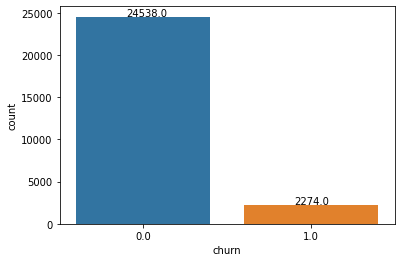

In [25]:
telecomchurn = sns.countplot(x=HV_telecom['churn'])

for p in telecomchurn.patches:
        telecomchurn.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
plt.show()

**Observations:** 
- There is clear evidence that Churn rate has class imabalance so we need to handel this.

### **<font color='green'>4.1.2 Average Revenue Per User (arpu) </font>**

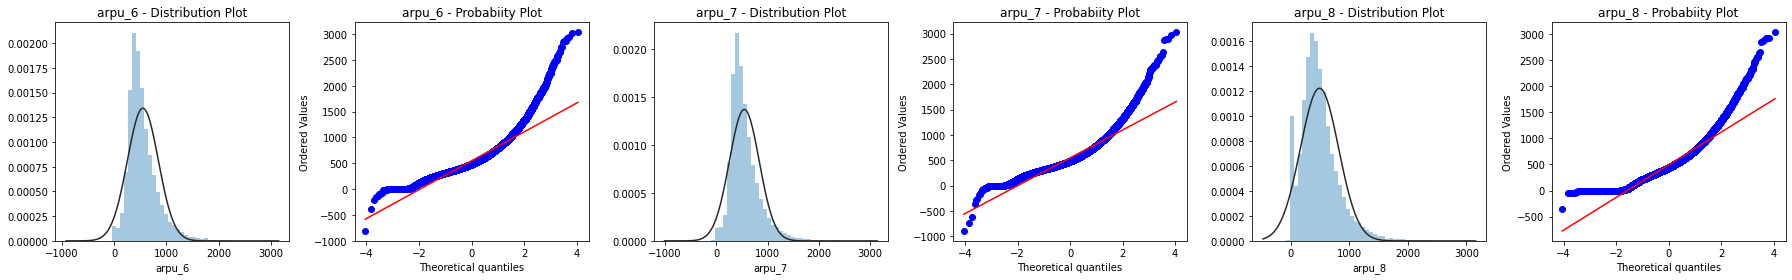

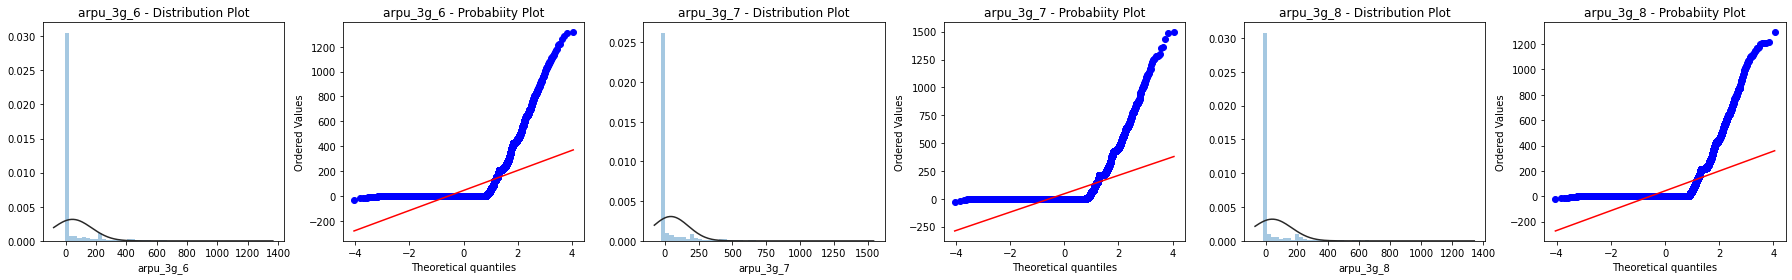

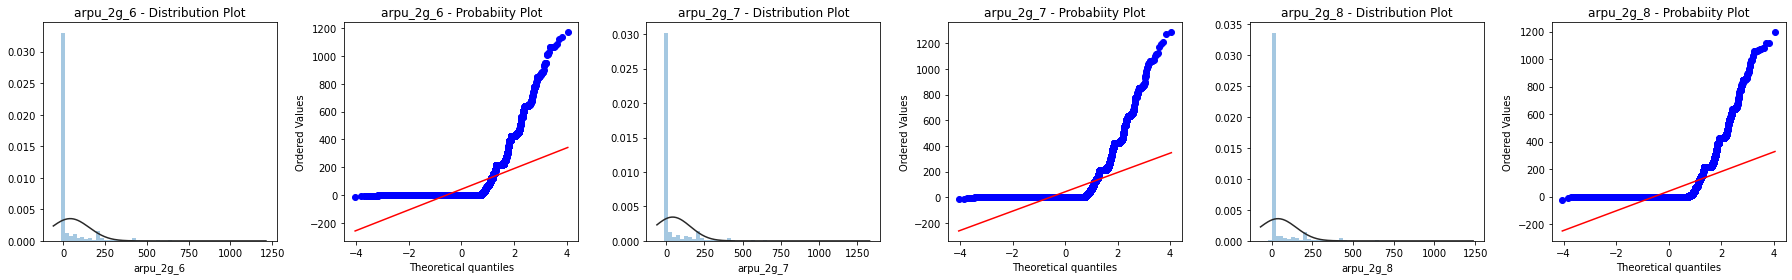

In [26]:
var_arpu = [var for var in HV_telecom.columns if ('arpu' in var and '6' in var)]
for f in var_arpu:
    dist_prob_plot(f)

**Observations:** 
- Based on distribution and probability plot for different **`arpu`**, we can see that there are many outliers with high value. We can consider them upper band of high value customers whom we have to retain.

### **<font color='green'>4.1.3 Recharge Amount </font>**

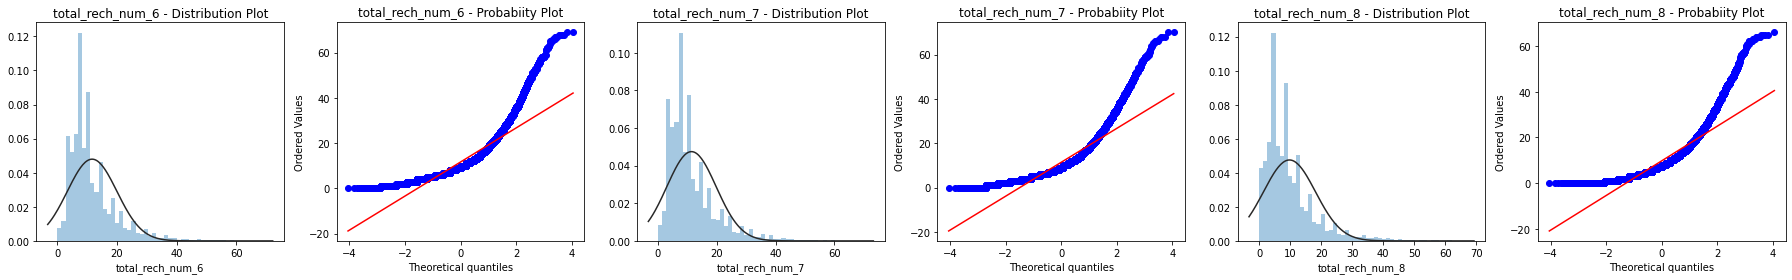

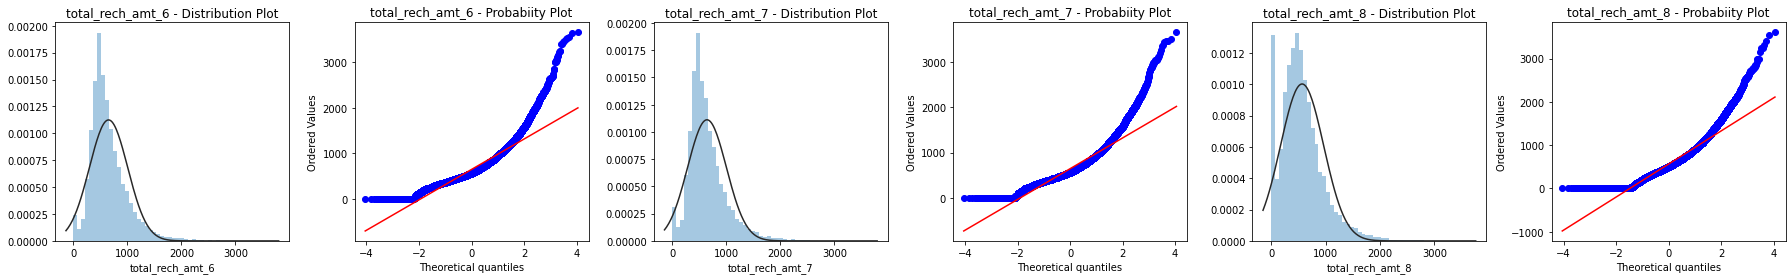

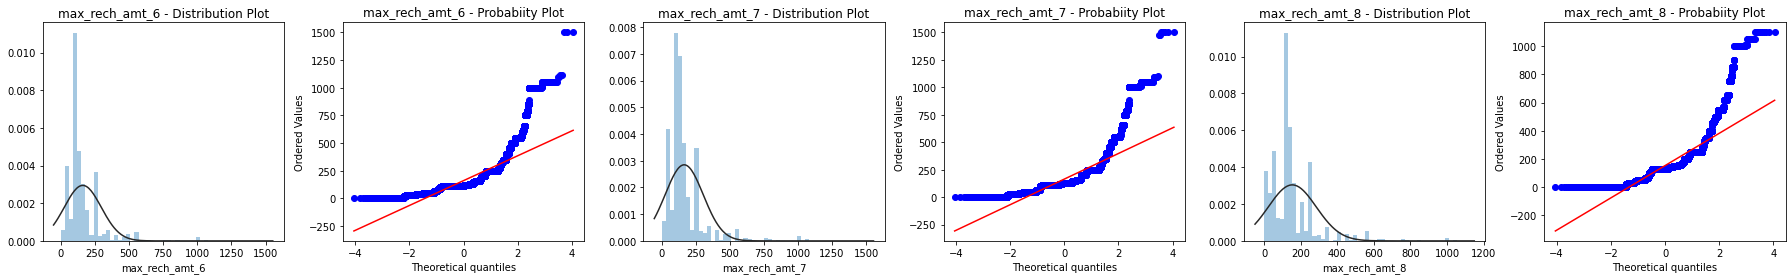

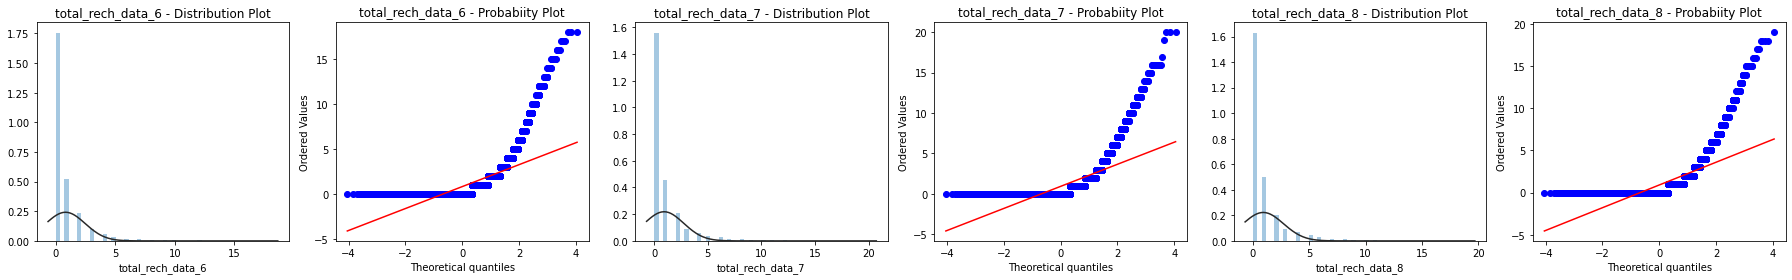

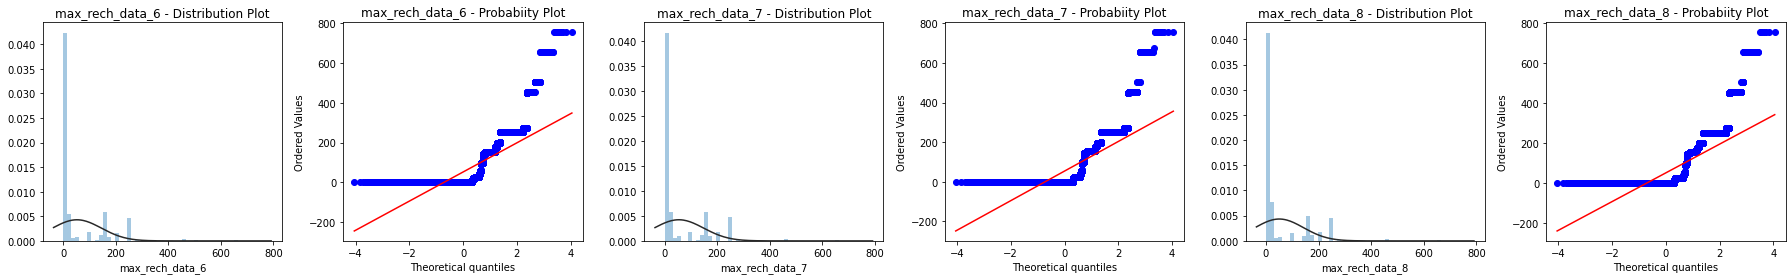

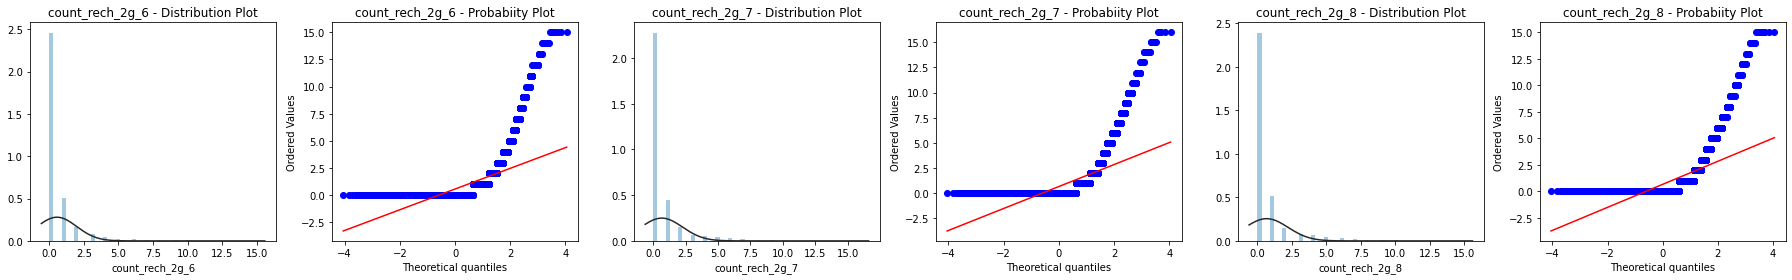

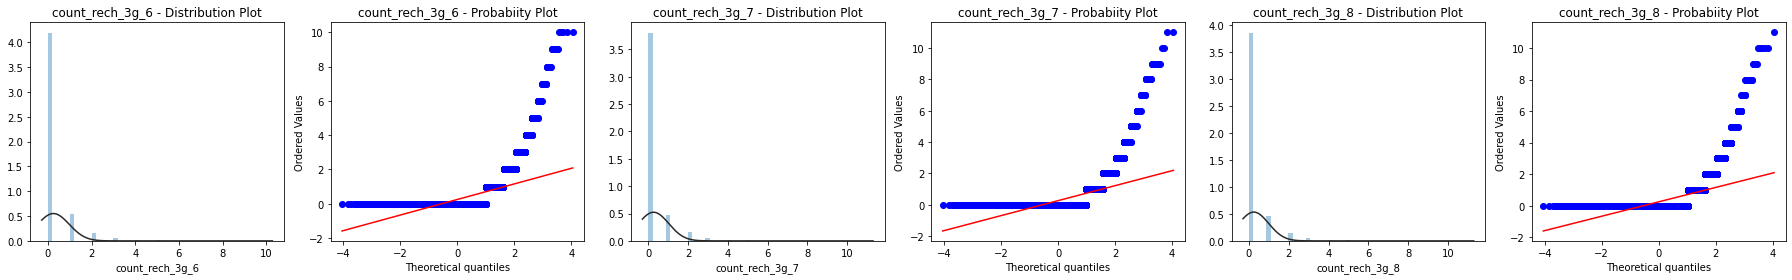

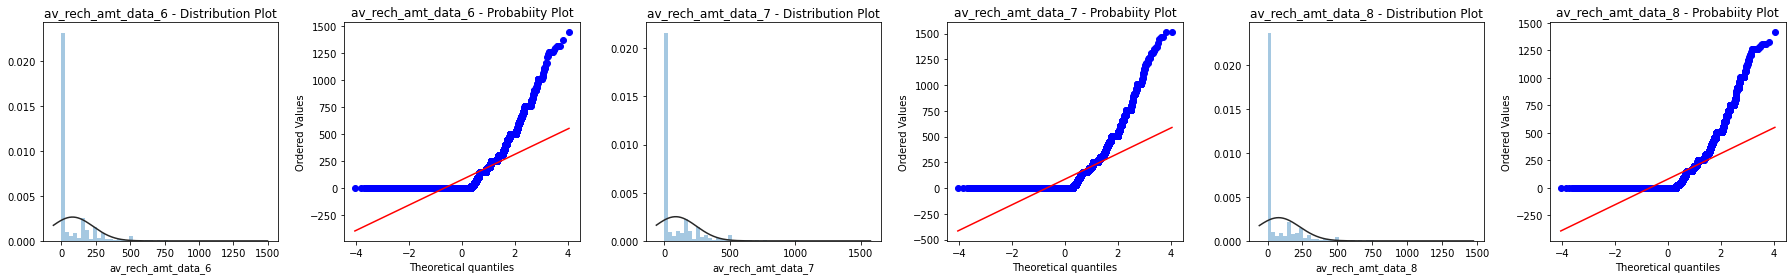

In [27]:
var_rech = [var for var in HV_telecom.columns if ('rech' in var and '6' in var and 'date' not in var)]
for f in var_rech:
    dist_prob_plot(f)

**Observations:** 
- No specific pattern visible.

### **<font color='green'>4.1.4 Selected Features </font>**

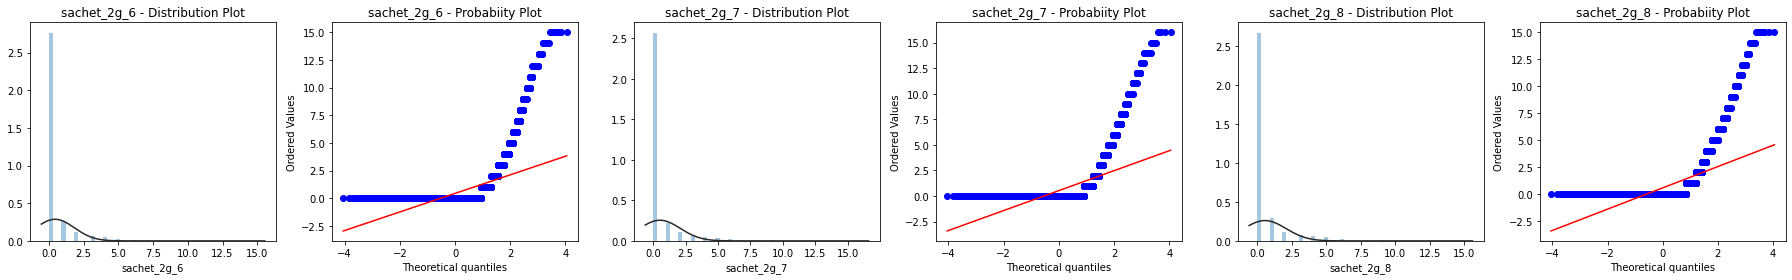

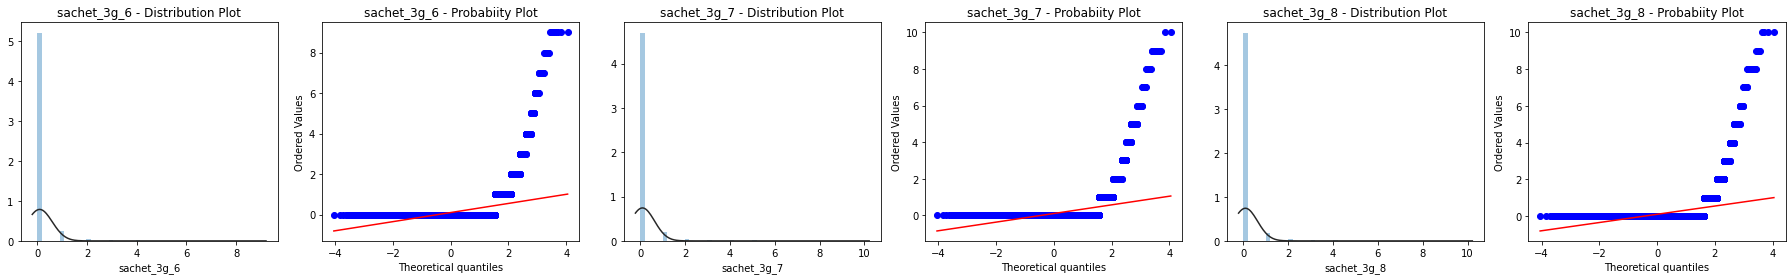

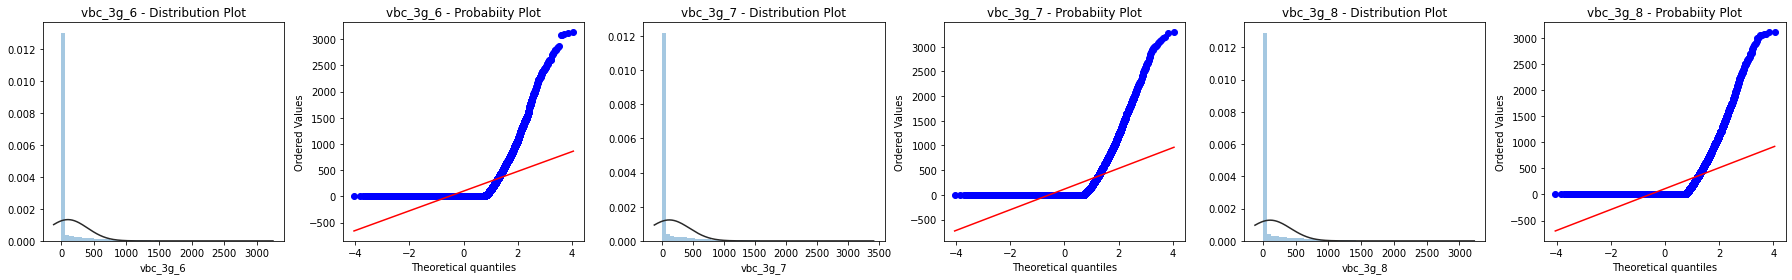

In [28]:
var_misc = [var for var in HV_telecom.columns if (('night' in var or 'sachet' in var or 'vbc' in var) and '6' in var)]
for f in var_misc:
    dist_prob_plot(f)

**Observations:** 
- Based on distribution and probability plot for different features, we can see that there are many outliers with high value. There is a special set of customers using these features.

## 4.2 Bivariate Analysis

### **<font color='green'>4.2.1 Age on network[aon] - number of days the customer is using the operator T network </font>**

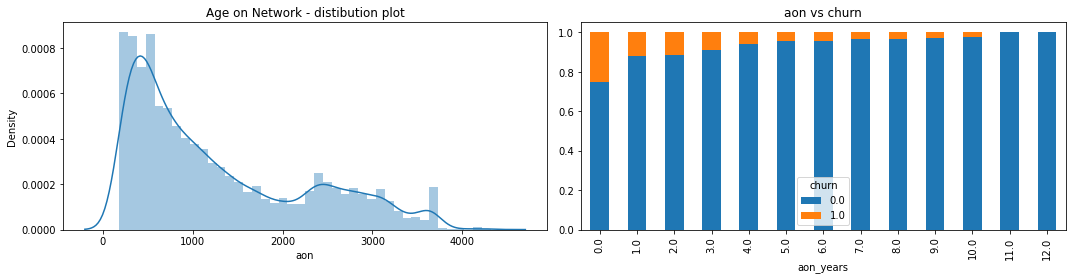

In [29]:
## As 'aon' is number of days,let us convert it into years for better analysis and rounding of to nearest year number
HV_telecom['aon_years'] = round(HV_telecom['aon']/(30*12))

##Plot the data
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1,2,1)
sns.distplot(HV_telecom['aon'],label='Age on Network - distribution plot',ax=ax1)
plt.title('Age on Network - distibution plot')
ax2 = plt.subplot(1,2,2)
pd.crosstab(HV_telecom.aon_years,HV_telecom.churn, normalize='index').plot(kind='bar',title='aon vs churn',ax=ax2,stacked=True)
plt.tight_layout()
plt.show()

HV_telecom.drop(columns='aon_years',inplace=True)

**Observations:** 
- Based on the above plots we can see that new customers are quiting more often.

### **<font color='green'>4.2.2 Recency - Data and Talktime </font>**

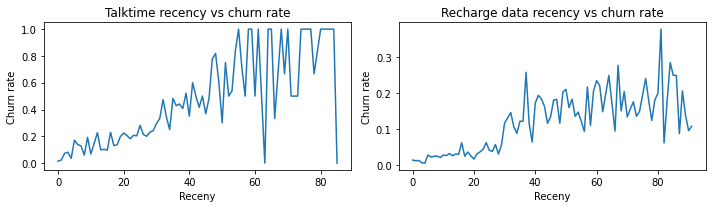

In [30]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
curn_rate = pd.crosstab(HV_telecom.recency_ap,HV_telecom.churn, normalize='index')
plt.xlabel('Receny')
plt.ylabel('Churn rate')
plt.title('Talktime recency vs churn rate')
plt.plot(curn_rate[1.0])

plt.subplot(1,2,2)
curn_rate = pd.crosstab(HV_telecom.recency_data_ap,HV_telecom.churn, normalize='index')
plt.xlabel('Receny')
plt.ylabel('Churn rate')
plt.title('Recharge data recency vs churn rate')
plt.plot(curn_rate[1.0])

plt.tight_layout()
plt.show()

**Observations:** 
- Based on the above plots we can see that during the early i,e the **Good Phase** the customers recharge both talktime and data is high.

### **<font color='green'>4.2.3 Good Vs Action Phase </font>**

In [31]:
var_avg = []
for v in range (0,len(columns_6)):
    var_avg.append(columns_6[v][:-2]+'_avg')
    HV_telecom[var_avg[v]] = (HV_telecom[columns_6[v]] + HV_telecom[columns_7[v]])/2

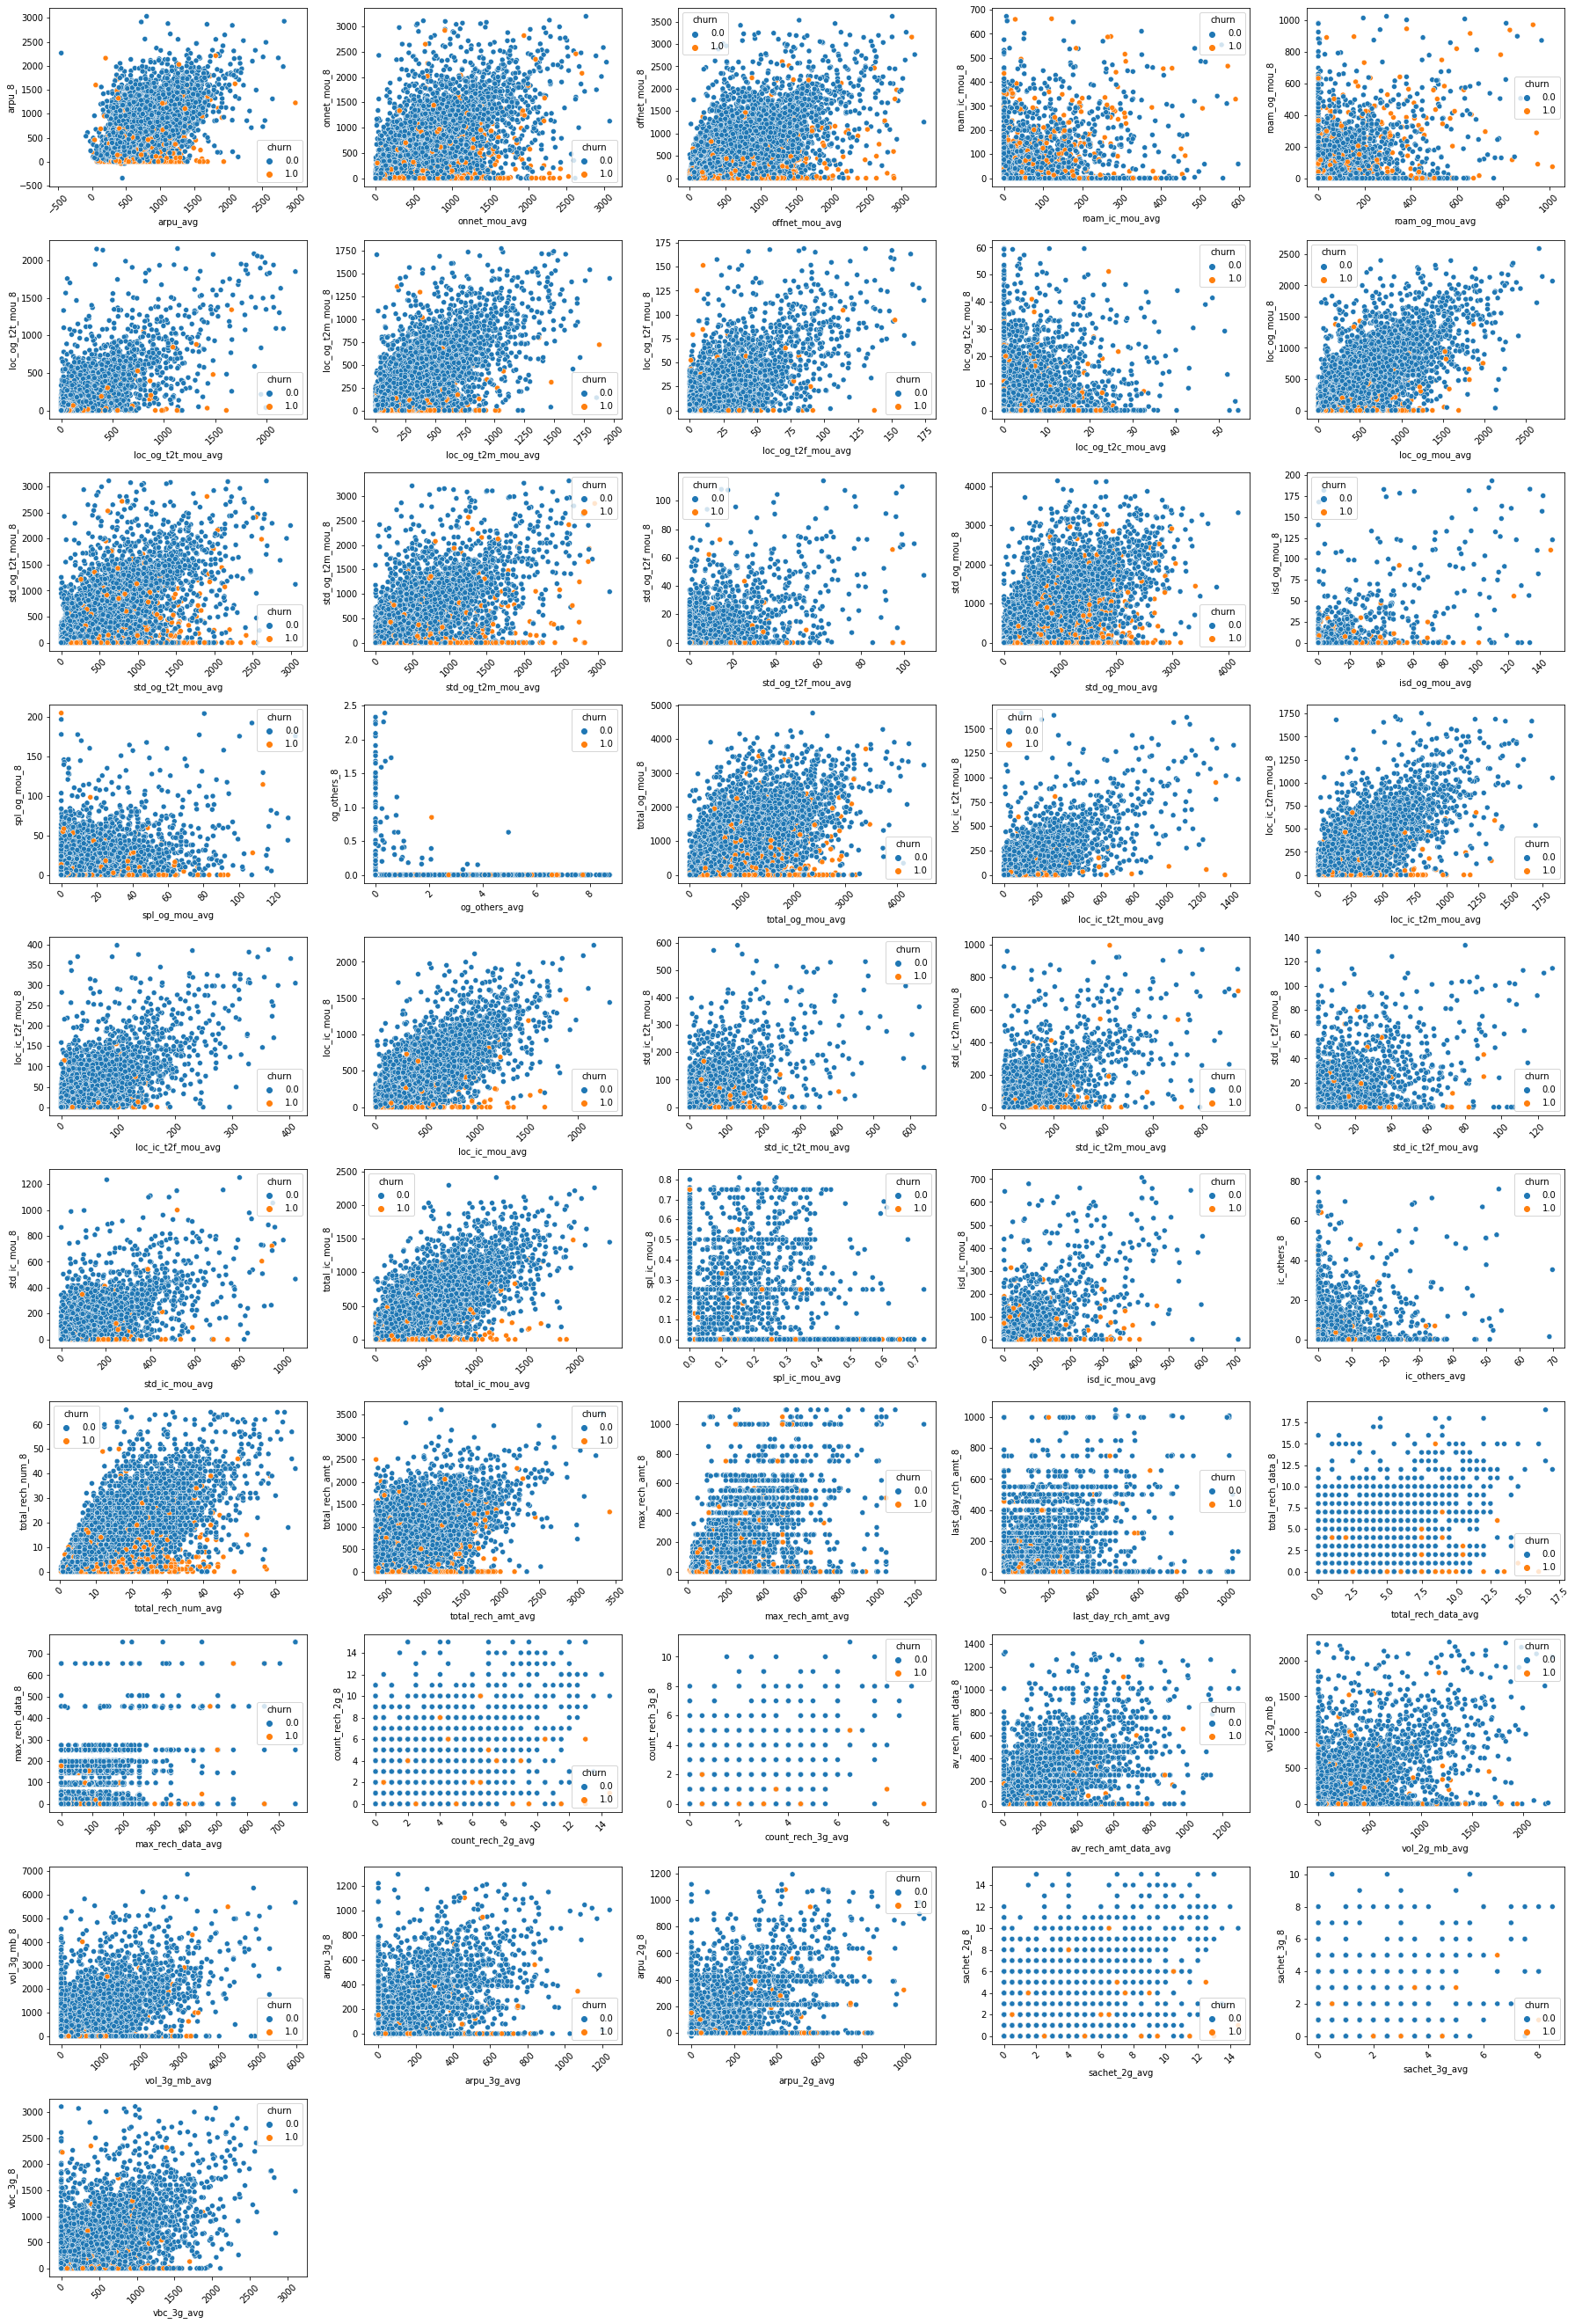

In [32]:
plt.figure(figsize=(25.0,(len(columns_8)/5)*4))
for n in range(1,len(columns_8)+1):
    mscatterplot(df=HV_telecom,x_colname=var_avg[n-1],y_colname=columns_8[n-1] ,hue_colname='churn',pltnum=n,listlen=len(columns_8)+1)

plt.tight_layout()
plt.show()

##Drop all the _avg columns created
HV_telecom.drop(columns=var_avg,inplace=True)

**Observations:** 
- The below features proves a gradual `decline in mou or recharge amount/number` in Action phase as compared to Good phase. It means some of these features may show why the customers are going to `churn`.

    -onnet_mou_,loc_ic_t2m_mou_, loc_ic_mou_, total_ic_mou_,total_rech_num_, sachet_2g_
    
    -offnet_mou_,roam_og_mou_ loc_og_mou_, std_og_t2t_mou_, std_og_t2m_mou_, std_og_mou_avg_, total_og_mou, loc_ic_t2t_mou_

In [33]:
HV_telecom_diff[['recency_ap','recency_data_ap', 'aon', 'churn']] = HV_telecom[['recency_ap','recency_data_ap', 'aon', 'churn']]
HV_telecom_diff.shape
display(HV_telecom_diff.describe())

arpu_diff    arpu_trend  onnet_mou_diff  onnet_mou_trend  \
count  26812.000000  26812.000000    26812.000000     26812.000000   
mean     -54.898590      0.403290      -33.742766         0.412315   
std      274.868674      0.490567      273.385248         0.492261   
min    -2045.424500      0.000000    -2614.860000         0.000000   
25%     -188.927875      0.000000      -73.381250         0.000000   
50%      -46.317500      0.000000       -9.232500         0.000000   
75%       83.867375      1.000000       27.801250         1.000000   
max     2718.573500      1.000000     2667.980000         1.000000   

       offnet_mou_diff  offnet_mou_trend  roam_ic_mou_diff  roam_ic_mou_trend  \
count     26812.000000      26812.000000      26812.000000       26812.000000   
mean        -46.143206          0.407728         -1.868824           0.752536   
std         298.329883          0.491421         44.097498           0.431547   
min       -2891.605000          0.000000       -559.275000           0.000000   
25%        -124.157500          0.000000          0.000000           1.000000   
50%         -23.190000          0.000000          0.000000           1.000000   
75%          53.282500          1.000000          0.000000           1.000000   
max        2700.795000          1.000000        666.750000           1.000000   

       roam_og_mou_diff  roam_og_mou_trend  loc_og_t2t_mou_diff  \
count      26812.000000       26812.000000         26812.000000   
mean          -4.213723           0.744368            -7.704609   
std           70.120837           0.436224           102.641668   
min         -940.560000           0.000000         -1955.535000   
25%           -0.355000           0.000000           -20.666250   
50%            0.000000           1.000000            -2.400000   
75%            0.000000           1.000000            10.206250   
max          980.610000           1.000000          1808.635000   

       loc_og_t2t_mou_trend  loc_og_t2m_mou_diff  loc_og_t2m_mou_trend  \
count          26812.000000         26812.000000          26812.000000   
mean               0.425556           -12.996036              0.426600   
std                0.494436           130.901970              0.494592   
min                0.000000         -1715.685000              0.000000   
25%                0.000000           -47.221250              0.000000   
50%                0.000000            -6.030000              0.000000   
75%                1.000000            24.823750              1.000000   
max                1.000000          1696.975000              1.000000   

       loc_og_t2f_mou_diff  loc_og_t2f_mou_trend  loc_og_t2c_mou_diff  \
count         26812.000000          26812.000000         26812.000000   
mean             -0.436705              0.573848             0.022812   
std               9.567237              0.494526             4.902442   
min            -137.120000              0.000000           -54.560000   
25%              -1.400000              0.000000            -0.280000   
50%               0.000000              1.000000             0.000000   
75%               0.370000              1.000000             0.000000   
max             141.470000              1.000000            59.630000   

       loc_og_t2c_mou_trend  loc_og_mou_diff  loc_og_mou_trend  \
count          26812.000000     26812.000000      26812.000000   
mean               0.701701       -21.137804          0.422572   
std                0.457520       182.351359          0.493978   
min                0.000000     -2092.980000          0.000000   
25%                0.000000       -71.545000          0.000000   
50%                1.000000        -9.522500          0.000000   
75%                1.000000        34.300000          1.000000   
max                1.000000      1692.135000          1.000000   

       std_og_t2t_mou_diff  std_og_t2t_mou_trend  std_og_t2m_mou_diff  \
count         26812.000000          26812.000000    

## 4.3 Dummy Variable Creation

In [34]:
hot_encoding = pd.get_dummies(data=HV_telecom[columns_cat_new],columns=columns_cat_new,drop_first=True)
HV_telecom_diff = pd.concat([HV_telecom_diff,hot_encoding],axis=1)
HV_telecom_diff.shape
display(HV_telecom_diff.describe())

arpu_diff    arpu_trend  onnet_mou_diff  onnet_mou_trend  \
count  26812.000000  26812.000000    26812.000000     26812.000000   
mean     -54.898590      0.403290      -33.742766         0.412315   
std      274.868674      0.490567      273.385248         0.492261   
min    -2045.424500      0.000000    -2614.860000         0.000000   
25%     -188.927875      0.000000      -73.381250         0.000000   
50%      -46.317500      0.000000       -9.232500         0.000000   
75%       83.867375      1.000000       27.801250         1.000000   
max     2718.573500      1.000000     2667.980000         1.000000   

       offnet_mou_diff  offnet_mou_trend  roam_ic_mou_diff  roam_ic_mou_trend  \
count     26812.000000      26812.000000      26812.000000       26812.000000   
mean        -46.143206          0.407728         -1.868824           0.752536   
std         298.329883          0.491421         44.097498           0.431547   
min       -2891.605000          0.000000       -559.275000           0.000000   
25%        -124.157500          0.000000          0.000000           1.000000   
50%         -23.190000          0.000000          0.000000           1.000000   
75%          53.282500          1.000000          0.000000           1.000000   
max        2700.795000          1.000000        666.750000           1.000000   

       roam_og_mou_diff  roam_og_mou_trend  loc_og_t2t_mou_diff  \
count      26812.000000       26812.000000         26812.000000   
mean          -4.213723           0.744368            -7.704609   
std           70.120837           0.436224           102.641668   
min         -940.560000           0.000000         -1955.535000   
25%           -0.355000           0.000000           -20.666250   
50%            0.000000           1.000000            -2.400000   
75%            0.000000           1.000000            10.206250   
max          980.610000           1.000000          1808.635000   

       loc_og_t2t_mou_trend  loc_og_t2m_mou_diff  loc_og_t2m_mou_trend  \
count          26812.000000         26812.000000          26812.000000   
mean               0.425556           -12.996036              0.426600   
std                0.494436           130.901970              0.494592   
min                0.000000         -1715.685000              0.000000   
25%                0.000000           -47.221250              0.000000   
50%                0.000000            -6.030000              0.000000   
75%                1.000000            24.823750              1.000000   
max                1.000000          1696.975000              1.000000   

       loc_og_t2f_mou_diff  loc_og_t2f_mou_trend  loc_og_t2c_mou_diff  \
count         26812.000000          26812.000000         26812.000000   
mean             -0.436705              0.573848             0.022812   
std               9.567237              0.494526             4.902442   
min            -137.120000              0.000000           -54.560000   
25%              -1.400000              0.000000            -0.280000   
50%               0.000000              1.000000             0.000000   
75%               0.370000              1.000000             0.000000   
max             141.470000              1.000000            59.630000   

       loc_og_t2c_mou_trend  loc_og_mou_diff  loc_og_mou_trend  \
count          26812.000000     26812.000000      26812.000000   
mean               0.701701       -21.137804          0.422572   
std                0.457520       182.351359          0.493978   
min                0.000000     -2092.980000          0.000000   
25%                0.000000       -71.545000          0.000000   
50%                1.000000        -9.522500          0.000000   
75%                1.000000        34.300000          1.000000   
max                1.000000      1692.135000          1.000000   

       std_og_t2t_mou_diff  std_og_t2t_mou_trend  std_og_t2m_mou_diff  \
count         26812.000000          26812.000000    

# **<font color='blue'>5. Model Building and Evaluation </font>**
Let's start building the model. The first step to model building is the usual test-train split. So let's perform that

In [35]:
# Split the dataframe into train and test sets

X = HV_telecom_diff.drop(columns='churn')
y = HV_telecom_diff['churn']
X_columns = X.columns
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.values
y_test = y_test.values
print('The X set contains {} rows and {} columns.'.format(*X.shape))
print('The y set contains {} rows.'.format(*y.shape))
print('The training set after 70-30 split contains {} rows and {} columns.'.format(*X_train.shape))
print('The training set after 70-30 split contains {} rows.'.format(*y_train.shape))

The X set contains 26812 rows and 103 columns.
The y set contains 26812 rows.
The training set after 70-30 split contains 18768 rows and 103 columns.
The training set after 70-30 split contains 18768 rows.


## 5.1 Scale the data

- Data is already split into train and test sets,now we will scale the data
- Let's scale all these columns using StandardScaler.
- For test set we will use transform only since the values are already fit using the training set.

In [36]:
#Let us first initialise the scaler
SS = StandardScaler()

In [37]:
#Columns to scale
X_cat_cols = list(hot_encoding.columns.values) + columns_cat_trend
X_num_cols = X_train.drop(X_cat_cols,axis=1).columns.tolist()


X_train = pd.concat([X_train[X_cat_cols],pd.DataFrame(SS.fit_transform(X_train.drop(X_cat_cols, axis=1)))], axis=1)
X_test = pd.concat([X_test[X_cat_cols],pd.DataFrame(SS.transform(X_test.drop(X_cat_cols, axis=1)))], axis=1)

X_train.columns = X_cat_cols+X_num_cols
X_test.columns = X_cat_cols+X_num_cols

In [38]:
# Check if all the variables are scaled in training dataset.
X_train.describe()

night_pck_user_0  night_pck_user_1     fb_user_0     fb_user_1  \
count      18768.000000      18768.000000  18768.000000  18768.000000   
mean           0.986626          0.004955      0.792679      0.093031   
std            0.114872          0.070221      0.405398      0.290483   
min            0.000000          0.000000      0.000000      0.000000   
25%            1.000000          0.000000      1.000000      0.000000   
50%            1.000000          0.000000      1.000000      0.000000   
75%            1.000000          0.000000      1.000000      0.000000   
max            1.000000          1.000000      1.000000      1.000000   

       monthly_2g_0  monthly_2g_1  monthly_3g_0  monthly_3g_1    arpu_trend  \
count  18768.000000  18768.000000  18768.000000  18768.000000  18768.000000   
mean       0.861733      0.054934      0.848998      0.061328      0.404678   
std        0.345189      0.227857      0.358060      0.239937      0.490843   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      1.000000      0.000000      0.000000   
50%        1.000000      0.000000      1.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       onnet_mou_trend  offnet_mou_trend  roam_ic_mou_trend  \
count     18768.000000      18768.000000       18768.000000   
mean          0.415068          0.406543           0.752877   
std           0.492747          0.491201           0.431350   
min           0.000000          0.000000           0.000000   
25%           0.000000          0.000000           1.000000   
50%           0.000000          0.000000           1.000000   
75%           1.000000          1.000000           1.000000   
max           1.000000          1.000000           1.000000   

       roam_og_mou_trend  loc_og_t2t_mou_trend  loc_og_t2m_mou_trend  \
count       18768.000000          18768.000000          18768.000000   
mean            0.745844              0.426897              0.427163   
std             0.435397              0.494640              0.494680   
min             0.000000              0.000000              0.000000   
25%             0.000000              0.000000              0.000000   
50%             1.000000              0.000000              0.000000   
75%             1.000000              1.000000              1.000000   
max             1.000000              1.000000              1.000000   

       loc_og_t2f_mou_trend  loc_og_t2c_mou_trend  loc_og_mou_trend  \
count          18768.000000          18768.000000      18768.000000   
mean               0.573956              0.703325          0.422741   
std                0.494513              0.456804          0.494008   
min                0.000000              0.000000          0.000000   
25%                0.000000              0.000000          0.000000   
50%                1.000000              1.000000          0.000000   
75%                1.000000              1.000000          1.000000   
max                1.000000              1.000000          1.000000   

       std_og_t2t_mou_trend  std_og_t2m_mou_trend  std_og_t2f_mou_trend  \
count          18768.000000          18768.000000          18768.000000   
mean               0.536338              0.449062              0.820652   
std                0.498691              0.497412              0.383654   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              1.000000   
50%                1.000000              0.000000              1.000000   
75%                1.000000              1.000000              1.000000   
max                1.000000              1.000000              1.000000   

       std_og_mou_trend  isd_og_mou_trend  spl_og_mou_trend  og_others_trend  \
count      18768.000000 

**Observations:** 
-  Looks like we have scaled the data appropriately

## 5.2 Apply PCA 

- Let us transform original dataset to reduced dimesion with PCA retaining 98% of variance.

In [39]:
pca = PCA(n_components=0.98,random_state=42)

In [40]:
#Let us do the transformation
Xtrain_reduced = pca.fit_transform(X_train)
Xtest_reduced = pca.transform(X_test)
print('No of components after PCA :', pca.n_components_)

No of components after PCA : 66


In [41]:
#The components are
components = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1],'Feature':X.columns })
components

PC1       PC2                 Feature
0   -0.000167  0.000809               arpu_diff
1    0.001131  0.002020              arpu_trend
2    0.005214  0.016064          onnet_mou_diff
3    0.016504  0.038819         onnet_mou_trend
4   -0.004096  0.006214         offnet_mou_diff
5    0.006091  0.005837        offnet_mou_trend
6   -0.004126  0.012155        roam_ic_mou_diff
7    0.015530  0.040310       roam_ic_mou_trend
8    0.102177  0.012581        roam_og_mou_diff
9    0.079414 -0.035526       roam_og_mou_trend
10   0.090155 -0.039037     loc_og_t2t_mou_diff
11  -0.014518  0.010245    loc_og_t2t_mou_trend
12  -0.011662  0.009768     loc_og_t2m_mou_diff
13   0.069212 -0.032043    loc_og_t2m_mou_trend
14   0.081481 -0.037661     loc_og_t2f_mou_diff
15   0.021498 -0.011748    loc_og_t2f_mou_trend
16   0.015104  0.002306     loc_og_t2c_mou_diff
17   0.088014 -0.042432    loc_og_t2c_mou_trend
18   0.057500 -0.030813         loc_og_mou_diff
19   0.065717 -0.028555        loc_og_mou_trend
20   0.003893 -0.000871     std_og_t2t_mou_diff
21   0.077728 -0.034792    std_og_t2t_mou_trend
22   0.004559 -0.001860     std_og_t2m_mou_diff
23   0.036368 -0.002180    std_og_t2m_mou_trend
24   0.012057 -0.006198     std_og_t2f_mou_diff
25   0.103963 -0.048598    std_og_t2f_mou_trend
26   0.060343 -0.027877         std_og_mou_diff
27   0.074325 -0.038916        std_og_mou_trend
28   0.027406 -0.012814         isd_og_mou_diff
29   0.081096 -0.042940        isd_og_mou_trend
30   0.035858 -0.021068         spl_og_mou_diff
31   0.047104 -0.024230        spl_og_mou_trend
32   0.007007 -0.004932          og_others_diff
33   0.054673 -0.027241         og_others_trend
34   0.086126 -0.044244       total_og_mou_diff
35   0.006349 -0.001689      total_og_mou_trend
36   0.010339 -0.001338     loc_ic_t2t_mou_diff
37   0.011224 -0.006688    loc_ic_t2t_mou_trend
38   0.076878  0.020059     loc_ic_t2m_mou_diff
39   0.099590  0.017032    loc_ic_t2m_mou_trend
40   0.058802  0.026872     loc_ic_t2f_mou_diff
41   0.041340  0.003786    loc_ic_t2f_mou_trend
42   0.027576  0.097710         loc_ic_mou_diff
43   0.024168  0.076548        loc_ic_mou_trend
44   0.015166  0.044406     std_ic_t2t_mou_diff
45   0.015124  0.072588    std_ic_t2t_mou_trend
46   0.028141  0.103291     std_ic_t2m_mou_diff
47   0.013755  0.058479    std_ic_t2m_mou_trend
48   0.014992  0.070315     std_ic_t2f_mou_diff
49   0.016886  0.082086    std_ic_t2f_mou_trend
50   0.021085  0.087538         std_ic_mou_diff
51   0.013229  0.035930        std_ic_mou_trend
52   0.004846  0.026474       total_ic_mou_diff
53   0.009701  0.042771      total_ic_mou_trend
54   0.282650  0.030485         spl_ic_mou_diff
55   0.201942 -0.089154        spl_ic_mou_trend
56   0.232509 -0.100885         isd_ic_mou_diff
57  -0.059173  0.050250        isd_ic_mou_trend
58  -0.049165  0.044338          ic_others_diff
59   0.124691 -0.055084         ic_others_trend
60   0.183080 -0.089376     total_rech_num_diff
61   0.057843 -0.025166    total_rech_num_trend
62   0.049699  0.025370     total_rech_amt_diff
63   0.204530 -0.096421    total_rech_amt_trend
64   0.174853 -0.079502       max_rech_amt_diff
65   0.180307 -0.079059      max_rech_amt_trend
66   0.026065 -0.011792   last_day_rch_amt_diff
67   0.236289 -0.105495  last_day_rch_amt_trend
68   0.026597  0.000115    total_rech_data_diff
69   0.081937  0.007516   total_rech_data_trend
70   0.035246 -0.017106      max_rech_data_diff
71   0.285118 -0.128048     max_rech_data_trend
72   0.111395 -0.060369      count_rech_2g_diff
73   0.163065 -0.087190     count_rech_2g_trend
74   0.058959 -0.037639      count_rech_3g_diff
75   0.186238 -0.100852     count_rech_3g_trend
76   0.079219 -0.047779   av_rech_amt_data_diff
77   0.099526 -0.051985  av_rech_amt_data_trend
78   0.030147 -0.017392          vol_2g_mb_diff
79   0.119526 -0.065578         vol_2g_mb_trend
80   0.209271 -0.110528          vol_3g_mb_diff
81   0.023999 -0.003029         vol_3g_mb_trend
82   0.043867 -0.005109   

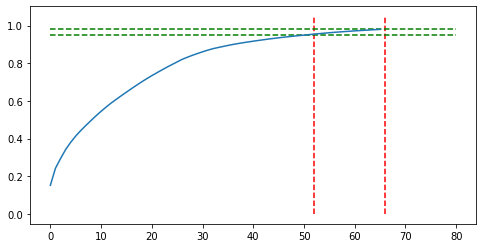

In [42]:
#Making the screeplot - plotting the cumulative variance against the number of components
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_).round(4))
plt.vlines(x=52,ymin=0,ymax=1.05,color='r',linestyles='dashed')
plt.vlines(x=66,ymin=0,ymax=1.05,color='r',linestyles='dashed')
plt.hlines(y=0.95,xmin=0,xmax=80,color='g',linestyles='dashed')
plt.hlines(y=0.98,xmin=0,xmax=80,color='g',linestyles='dashed')
plt.show()

**Observations:** 
-  We can comfortably say around 95% of the data is explained by 60-66 variables.

### **<font color='green'>5.2.1 Model Evaluation Criteria </font>**

We plan to consider the below criterion during model evaluation 
- During cross-validation following evaluation metrics are generated `['recall','precision', 'accuracy', 'f1']`
- Best `recall/sensitivity` model is selected because accuracy of churn prediction has higher importance
- We also have to ensure that this selection does not lead to very high false-positive rate by observing f1_score
- For f1_score, a cutoff of about 0.3-0.5 appears to give the best predictive performance. It is intuitive that the cutoff is less than 0.5 because the training data contains many fewer examples of `churn`

## 5.3 Handling Class-Imbalance

**Remarks**
- Various oversampling(`SMOTE, ADASYN`), undersampling(`ClusterCentroids, RandomUnderSampler`) and Hybrid sampling techniques(`SMOTEENN, SMOTETomek`) were tried to tackle class imbalance issue present in the data set. 
- After resampling the dataset, it is found that the models are getting `overfitted` to resampled training data. Parameter tuning using GridSerchCV (Holdout test data is also part of resampled data) is also not reliable due to this issue. 
- Cross-validation results were good, but the same model was `not performing well on test data`. Due to this issue instead of resampling techniques, `class_weight` parameter is used for  handling Class imbalance

## 5.4 Various ML Models with PCA 

#### <font color='red'>NOTE - The various values of the hypermeters are included and commented to make the whole process faster.I have only kept the ones which is giving best resultsfor each model as active for code execution

In [43]:
#Let us first write a function to perform the model evaluation through plots & using common scoring metrics

def model_evaluation_plot(y_train,y_train_pred,y_test,y_test_pred):
    
    print('\n------------Recall/Sensitivity (Churn Prediction Accuracy) score------------')
    print('train set:', round(recall_score(y_train, y_train_pred),3))
    print('Test set:',  round(recall_score(y_test, y_test_pred),3))

    print('\n------------Specificity (Non Churn Prediction Accuracy) score------------')
    tn1, fp1, fn1, tp1 = confusion_matrix(y_train, y_train_pred).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(y_test, y_test_pred).ravel()
    print('train set:', round((tn1/(tn1+fp1)),3))
    print('test set:', round((tn2/(tn2+fp2)),3))
        
    print('\n------------Precision score------------')
    print('train set:', round(precision_score(y_train, y_train_pred),3))
    print('test set:',  round(precision_score(y_test, y_test_pred),3))
    
    print('\n------------F1 score------------')
    print('train set:', round(f1_score(y_train, y_train_pred),3))
    print('test set:',  round(f1_score(y_test, y_test_pred),3))
    
    print('\n------------Accuracy score------------')
    print('train set:', round(accuracy_score(y_train, y_train_pred),3))
    print('Test set:',  round(accuracy_score(y_test, y_test_pred),3))
    
    print('\n------------Confusion Matrix------------')
    
    plt.figure(figsize=(8, 2))    
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred, normalize='true'), annot=True, cbar=False)
    plt.ylabel('Actual churn')   
    plt.xlabel('Predicted churn')
    plt.title('Training set')
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred, normalize='true'), annot=True, cbar=False)
    plt.ylabel('Actual churn')   
    plt.xlabel('Predicted churn')
    plt.title('Test set')

### **<font color='green'>5.4.1 XGBOOST </font>**

#### **Hyper parameter tuning:**
The key parameters to tune the model:         

**1. learning_rate & n_estimators***: Below learning rates are used with other parameters keeping at default values to check best combination of learning rate and n_estimators. 
- With lower learning rate, higher number of n_estimators are required to reach global minima.

learning_rate: 0.001,0.005,0.01,0.05,0.1,0.5,1

n_estimators: range(100,1300,100)

**2. max_depth***: This is used to **control over-fitting*** as higher depth will allow model to practically memorise the data.
- max_depth tried were in range(3,11,1) 

**3. gamma**: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
- gamma values in range of 0 to 0.4 is tried and best value will be selected for modelling.

**4. reg_alpha & reg_lambda:** 
- L1 regularization term on weight (analogous to Lasso regression). It can be used in case of very high dimensionality so that the algorithm runs faster when implemented
- L2 regularization term on weights (analogous to Ridge regression)
- Below combinations were tried to tune the model but it seems default values of 0 and 1 respectively works better.
'reg_alpha':[0.01,0.1,1,10,100],
'reg_lambda':[0.01,0.1,1,10],

**5. scale_pos_weight:**
- **Imbalance in classes** is handled by `scale_pos_weight` parameter
- Prediction accuracy of churn customer is more important than prediction accuracy of non-churn customers, so this pupose scale_pos_weight' : `[16]` is used instead of `balanced` option

In [44]:
#Hyperparameter tuning with XGBoost

#Specify range of hyperparameters - only the ones with best results are not commented
param_grid = { #'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.5,1],
              'learning_rate':[0.01],
              #'max_depth': range(3,11,1),
              'max_depth': [3],
              #'n_estimators':range(100,1300,100),
              'n_estimators': [500],
              #'gamma': [0,0.1,0.2,0.3,0.4],
              'gamma': [0],
              #'reg_alpha':[0.01,0.1,1,10,100],
              #'reg_lambda':[0.01,0.1,1,10],   
              'scale_pos_weight': [16] 
             }

#Specify model
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scoring = ['recall','precision', 'accuracy', 'f1']
xgb = XGBClassifier(random_state=42)

#Set up GridSearchCV()
model_cv_xgb = GridSearchCV(estimator = xgb,
                        param_grid = param_grid, 
                        scoring= scoring, 
                        refit='recall',
                        cv = folds,
                        verbose = 3,
                        return_train_score=True) 

model_cv_xgb.fit(Xtrain_reduced, y_train)
cv_result_xgb =pd.DataFrame(model_cv_xgb.cv_results_)
display(cv_result_xgb)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[20:12:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500, scale_pos_weight=16; accuracy: (train=0.818, test=0.812) f1: (train=0.442, test=0.417) precision: (train=0.297, test=0.281) recall: (train=0.871, test=0.808) total time=  31.5s
[20:13:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=500

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_gamma  \
0      31.842935      0.397184         0.035242        0.005923           0   

  param_learning_rate param_max_depth param_n_estimators  \
0                0.01               3                500   

  param_scale_pos_weight                                             params  \
0                     16  {'gamma': 0, 'learning_rate': 0.01, 'max_depth...   

   split0_test_recall  split1_test_recall  split2_test_recall  \
0            0.807692            0.810897            0.855769   

   split3_test_recall  split4_test_recall  mean_test_recall  std_test_recall  \
0            0.790997             0.78135          0.809341         0.025615   

   rank_test_recall  split0_train_recall  split1_train_recall  \
0                 1             0.870787             0.873194   

   split2_train_recall  split3_train_recall  split4_train_recall  \
0             0.871589               0.8749             0.864475   

   mean_train_recall  std_train_recall  split0_test_precision  \
0           0.870989          0.003549                0.28125   

   split1_test_precision  split2_test_precision  split3_test_precision  \
0               0.292824               0.278706                0.27033   

   split4_test_precision  mean_test_precision  std_test_precision  \
0                   0.27             0.278622            0.008387   

   rank_test_precision  split0_train_precision  split1_train_precision  \
0                    1                 0.29661                0.303064   

   split2_train_precision  split3_train_precision  split4_train_precision  \
0                0.291231                0.300634                0.303833   

   mean_train_precision  std_train_precision  split0_test_accuracy  \
0              0.299074              0.00466              0.812467   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.821524              0.803942              0.805755   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.806821            0.810102           0.006382   

   rank_test_accuracy  split0_train_accuracy  split1_train_accuracy  \
0                   1               0.817903               0.822832   

   split2_train_accuracy  split3_train_accuracy  split4_train_accuracy  \
0               0.813308               0.820579               0.824242   

   mean_train_accuracy  std_train_accuracy  split0_test_f1  split1_test_f1  \
0             0.819773             0.00388        0.417219        0.430272   

   split2_test_f1  split3_test_f1  split4_test_f1  mean_test_f1  std_test_f1  \
0        0.420472        0.402948        0.401321      0.414447     0.010945   

   rank_test_f1  split0_train_f1  split1_train_f1  split2_train_f1  \
0             1         0.442496         0.449959         0.436583   

   split3_train_f1  split4_train_f1  mean_train_f1  std_train_f1  
0         0.447498         0.449635       0.445234      0.005082


 The Best Estimator is: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=16, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[20:16:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

------------Recall/Sensitivity (Churn Prediction Accuracy) score------------
train set:

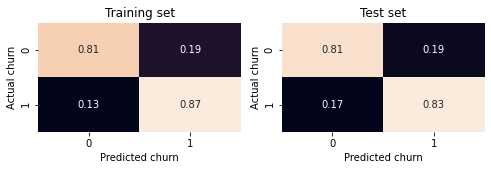

In [45]:
#Let us select the best estimator
xgb_best = model_cv_xgb.best_estimator_
print("\n The Best Estimator is:",xgb_best)
xgb_best.fit(Xtrain_reduced, y_train)

#PREDICT Churn rate
y_train_pred = xgb_best.predict(Xtrain_reduced)
y_test_pred = xgb_best.predict(Xtest_reduced)

model_evaluation_plot(y_train,y_train_pred,y_test,y_test_pred)

### **<font color='green'>5.4.2 RANDOM FOREST </font>**

#### **Hyper parameter tuning:**

The key parameters to tune the model: 

**1. n_estimators** represents number of trees in the foreset

'n_estimators': range(100,300,100)
 
**2. max_depth** , max number of levels in each decision tree, trucation parameter which limits the growth of the tree

'max_depth': [ 8, 10, 12]

**3. min_samples_split** ,The minimum number of samples required to split an internal node:

'min_samples_split': [500,750,1000]

**4. class_weight:**
- Imbalance in classes is handled by `class_weight` parameter
- Prediction accuracy of churn customer is more important than prediction accuracy of non-churn customers, so this pupose class_weight' : `[ {0:1, 1:16} ]` is used instead of `balanced` option

In [46]:
# Create the parameter grid based on the results of random search 
param_grid = { 
            # 'max_depth': [ 8, 10, 12],
              'max_depth': [10],
            #'min_samples_split': [500,750,1000],
             'min_samples_split': [750],     
            #'class_weight' : ['balanced', {0:1, 1:16}] ,      
             'class_weight' : [ {0:1, 1:16} ]  ,
            # 'n_estimators': range(100,300,100)
             'n_estimators': [200]
            }

#class_weight='balanced_subsample'
#folds = 5
folds = StratifiedKFold(n_splits=5)
scoring = ['recall','precision', 'accuracy', 'f1']

rf = RandomForestClassifier( random_state=42)
model_cv = GridSearchCV(estimator = rf, param_grid = param_grid,scoring=scoring, refit='recall', cv = folds, verbose =3, return_train_score=True)
model_cv.fit(Xtrain_reduced, y_train)
cv_result =pd.DataFrame(model_cv.cv_results_)
display(cv_result)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight={0: 1, 1: 16}, max_depth=10, min_samples_split=750, n_estimators=200; accuracy: (train=0.801, test=0.792) f1: (train=0.417, test=0.388) precision: (train=0.276, test=0.257) recall: (train=0.856, test=0.795) total time=  15.1s
[CV 2/5] END class_weight={0: 1, 1: 16}, max_depth=10, min_samples_split=750, n_estimators=200; accuracy: (train=0.809, test=0.806) f1: (train=0.426, test=0.406) precision: (train=0.284, test=0.272) recall: (train=0.855, test=0.798) total time=  14.6s
[CV 3/5] END class_weight={0: 1, 1: 16}, max_depth=10, min_samples_split=750, n_estimators=200; accuracy: (train=0.816, test=0.808) f1: (train=0.434, test=0.406) precision: (train=0.291, test=0.273) recall: (train=0.848, test=0.788) total time=  14.2s
[CV 4/5] END class_weight={0: 1, 1: 16}, max_depth=10, min_samples_split=750, n_estimators=200; accuracy: (train=0.805, test=0.806) f1: (train=0.419, test=0.417) precision: (train=0.279

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      14.267095      0.504861         0.108595        0.013997   

  param_class_weight param_max_depth param_min_samples_split  \
0      {0: 1, 1: 16}              10                     750   

  param_n_estimators                                             params  \
0                200  {'class_weight': {0: 1, 1: 16}, 'max_depth': 1...   

   split0_test_recall  split1_test_recall  split2_test_recall  \
0            0.794872            0.798077            0.788462   

   split3_test_recall  split4_test_recall  mean_test_recall  std_test_recall  \
0            0.839228             0.78135          0.800398         0.020244   

   rank_test_recall  split0_train_recall  split1_train_recall  \
0                 1             0.855538             0.854735   

   split2_train_recall  split3_train_recall  split4_train_recall  \
0             0.847512             0.847634             0.862069   

   mean_train_recall  std_train_recall  split0_test_precision  \
0           0.853498          0.005466               0.256729   

   split1_test_precision  split2_test_precision  split3_test_precision  \
0               0.271834               0.273333                0.27766   

   split4_test_precision  mean_test_precision  std_test_precision  \
0               0.255789             0.267069            0.009036   

   rank_test_precision  split0_train_precision  split1_train_precision  \
0                    1                0.275523                0.283622   

   split2_train_precision  split3_train_precision  split4_train_precision  \
0                 0.29131                0.278524                0.285904   

   mean_train_precision  std_train_precision  split0_test_accuracy  \
0              0.282977             0.005546              0.791689   

   split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
0              0.805541              0.808205              0.805755   

   split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
0              0.793499            0.800938           0.006901   

   rank_test_accuracy  split0_train_accuracy  split1_train_accuracy  \
0                   1               0.801319               0.808778   

   split2_train_accuracy  split3_train_accuracy  split4_train_accuracy  \
0               0.816238               0.804995               0.809724   

   mean_train_accuracy  std_train_accuracy  split0_test_f1  split1_test_f1  \
0             0.808211            0.004998        0.388106        0.405537   

   split2_test_f1  split3_test_f1  split4_test_f1  mean_test_f1  std_test_f1  \
0        0.405941        0.417266        0.385408      0.400452     0.011979   

   rank_test_f1  split0_train_f1  split1_train_f1  split2_train_f1  \
0             1         0.416813         0.425915         0.433587   

   split3_train_f1  split4_train_f1  mean_train_f1  std_train_f1  
0         0.419278         0.429399       0.424998      0.006224


------------Recall/Sensitivity (Churn Prediction Accuracy) score------------
train set: 0.854
Test set: 0.823

------------Specificity (Non Churn Prediction Accuracy) score------------
train set: 0.805
test set: 0.802

------------Precision score------------
train set: 0.284
test set: 0.289

------------F1 score------------
train set: 0.426
test set: 0.427

------------Accuracy score------------
train set: 0.809
Test set: 0.804

------------Confusion Matrix------------


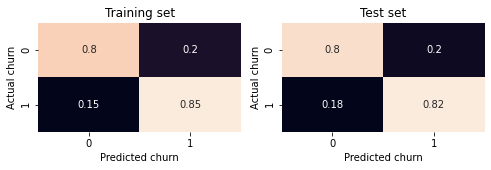

In [47]:
#Let us select the best estimator
clf_best = model_cv.best_estimator_
clf_best.fit(Xtrain_reduced, y_train)

y_train_pred = clf_best.predict(Xtrain_reduced)
y_pred = clf_best.predict(Xtest_reduced)

model_evaluation_plot(y_train,y_train_pred,y_test,y_pred)

### **<font color='green'>5.4.3 SUPPORT VECTOR MACHINES </font>**

#### **Hyper parameter tuning:**

The key parameters to tune the model: 

**1. Kernal** 3 combinations (`linear`, `poly`, `rbf`) have been tried with along with other paramaters
Out of which `rbf` has given best results as it is capable of transforming highly nonlinear feature spaces to linear ones. It is even capable of creating elliptical (i.e. enclosed) decision boundaries
 
**2. C(cost)** C is analogous to the ***penalty imposed for misclassification***, i.e. a higher C will force the model to classify most (training) data points correctly (and thus, overfit).

Below combinations have been tried with along with other paramaters
- Iteration 1: C values [1, 10, 100, 1000] to itentify which range of cost to be tuned futher. We found that cost between 1 to 10 are giving better results
- Iteration 2: C values in the range from 1 to 10 were tried and best value was kept for modelling

**3. gamma** It defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’
- gamma values [0.0001,0.001,0.01,0.1,1] were tried and best value was kept for modelling


**4. class_weight:**
- Imbalance in classes is handled by `class_weight` parameter
- Prediction accuracy of churn customer is more important than prediction accuracy of non-churn customers, so this pupose class_weight' : `[ {0:1, 1:16} ]` is used instead of `balanced` option

In [48]:
# specify range of hyperparameters
param_grid = {#'C': [1,10,100,1000],
              #'C': range(1,11,1),  
               'C': [2],
              #'gamma': [0.0001,0.001,0.01,0.1,1], 
               'gamma': [0.001], 
              #'kernel': ['linear','rbf','poly'],
              'kernel': ['rbf'],
              'class_weight': [{0:1, 1:16}]
             }

# specify model
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scoring = ['recall','precision', 'accuracy', 'f1']
svc = SVC(random_state=42)

# set up GridSearchCV()
model_cv_svc = GridSearchCV(estimator = svc,
                        param_grid = param_grid, 
                        scoring= scoring, 
                        refit='recall',
                        cv = folds,
                        verbose = 3,
                        return_train_score=True) 

model_cv_svc.fit(Xtrain_reduced, y_train)
cv_result_svc =pd.DataFrame(model_cv_svc.cv_results_)
display(cv_result_svc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=2, class_weight={0: 1, 1: 16}, gamma=0.001, kernel=rbf; accuracy: (train=0.807, test=0.801) f1: (train=0.426, test=0.409) precision: (train=0.283, test=0.271) recall: (train=0.863, test=0.827) total time=  31.3s
[CV 2/5] END C=2, class_weight={0: 1, 1: 16}, gamma=0.001, kernel=rbf; accuracy: (train=0.811, test=0.815) f1: (train=0.431, test=0.430) precision: (train=0.287, test=0.289) recall: (train=0.864, test=0.843) total time=  27.7s
[CV 3/5] END C=2, class_weight={0: 1, 1: 16}, gamma=0.001, kernel=rbf; accuracy: (train=0.804, test=0.808) f1: (train=0.423, test=0.423) precision: (train=0.280, test=0.282) recall: (train=0.865, test=0.846) total time=  25.0s
[CV 4/5] END C=2, class_weight={0: 1, 1: 16}, gamma=0.001, kernel=rbf; accuracy: (train=0.813, test=0.797) f1: (train=0.435, test=0.396) precision: (train=0.291, test=0.263) recall: (train=0.867, test=0.804) total time=  25.7s
[CV 5/5] END C=2, class_weight={0

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0      21.338805      2.233361         5.510829        0.773815       2   

  param_class_weight param_gamma param_kernel  \
0      {0: 1, 1: 16}       0.001          rbf   

                                              params  split0_test_recall  \
0  {'C': 2, 'class_weight': {0: 1, 1: 16}, 'gamma...            0.826923   

   split1_test_recall  split2_test_recall  split3_test_recall  \
0            0.842949            0.846154            0.803859   

   split4_test_recall  mean_test_recall  std_test_recall  rank_test_recall  \
0            0.819936          0.827964         0.015505                 1   

   split0_train_recall  split1_train_recall  split2_train_recall  \
0             0.862761             0.864366             0.865169   

   split3_train_recall  split4_train_recall  mean_train_recall  \
0             0.866881             0.864475            0.86473   

   std_train_recall  split0_test_precision  split1_test_precision  \
0          0.001334               0.271293               0.289011   

   split2_test_precision  split3_test_precision  split4_test_precision  \
0               0.282353               0.262605               0.268987   

   mean_test_precision  std_test_precision  rank_test_precision  \
0              0.27485            0.009527                    1   

   split0_train_precision  split1_train_precision  split2_train_precision  \
0                0.283193                0.287353                0.280218   

   split3_train_precision  split4_train_precision  mean_train_precision  \
0                0.290591                0.289241              0.286119   

   std_train_precision  split0_test_accuracy  split1_test_accuracy  \
0             0.003864              0.801012              0.814598   

   split2_test_accuracy  split3_test_accuracy  split4_test_accuracy  \
0              0.808471              0.796696              0.800426   

   mean_test_accuracy  std_test_accuracy  rank_test_accuracy  \
0            0.804241           0.006435                   1   

   split0_train_accuracy  split1_train_accuracy  split2_train_accuracy  \
0                0.80738               0.810843               0.804383   

   split3_train_accuracy  split4_train_accuracy  mean_train_accuracy  \
0               0.813187               0.812321             0.809623   

   std_train_accuracy  split0_test_f1  split1_test_f1  split2_test_f1  \
0            0.003285        0.408551        0.430442        0.423416   

   split3_test_f1  split4_test_f1  mean_test_f1  std_test_f1  rank_test_f1  \
0        0.395883        0.405083      0.412675     0.012551             1   

   split0_train_f1  split1_train_f1  split2_train_f1  split3_train_f1  \
0         0.426418         0.431318         0.423326         0.435273   

   split4_train_f1  mean_train_f1  std_train_f1  
0         0.433454       0.429958      0.004446


 Best Estimator: SVC(C=2, class_weight={0: 1, 1: 16}, gamma=0.001, random_state=42)

------------Recall/Sensitivity (Churn Prediction Accuracy) score------------
train set: 0.861
Test set: 0.848

------------Specificity (Non Churn Prediction Accuracy) score------------
train set: 0.807
test set: 0.807

------------Precision score------------
train set: 0.288
test set: 0.3

------------F1 score------------
train set: 0.431
test set: 0.444

------------Accuracy score------------
train set: 0.811
Test set: 0.811

------------Confusion Matrix------------


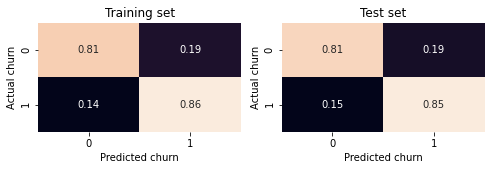

In [49]:
#Let us select the best estimator
svc_best = model_cv_svc.best_estimator_
print("\n Best Estimator:",svc_best)
svc_best.fit(Xtrain_reduced, y_train)

#PREDICT Churn rate
y_train_pred = svc_best.predict(Xtrain_reduced)
y_test_pred = svc_best.predict(Xtest_reduced)

model_evaluation_plot(y_train,y_train_pred,y_test,y_test_pred)

**Observations:** 
-  Based on `Recall/Sensitivity` and `F1` score, ***`SVM`*** provides best results for data after applying PCA.

## 5.5 Model without PCA 

- Let us derive a model without PCA to identify `important churn indicators` and `business recommendation`.
- We didn't use SVM for modelling with PCA as `coef_` assigned to the features is only available in the case of `linear kernel`;however the with the current data set `rbf` provides best results.

### **<font color='green'>5.5.1 RANDOM FOREST </font>**

#### **Hyper parameter tuning:**

The key parameters to tune the model: 

**1. n_estimators** represents number of trees in the foreset

'n_estimators': range(100,300,100)
 
**2. max_depth** , max number of levels in each decision tree, trucation parameter which limits the growth of the tree

'max_depth': [ 8, 10, 12]

**3. class_weight:**
- Imbalance in classes is handled by `class_weight` parameter
- Prediction accuracy of churn customer is more important than prediction accuracy of non-churn customers, so this pupose class_weight' : `[ {0:1, 1:16} ]` is used instead of `balanced` option

**4. max_features** , max number of features considered for splitting a node

'max_features': ['sqrt', 30,40, 50, 60]

**5. min_samples_leaf** , min number of data points allowed in a leaf node, trucation parameter which limits the growth of the tree

'min_samples_leaf': range(50,200 ,50)

In [50]:
# hyperparameter tuning with Random Forest

# specify range of hyperparameters
param_grid = {
    
    #  'max_depth': [ 8, 10, 12],
      'max_depth': [10],
    # 'max_features': ['sqrt', 30,40, 50, 60],
     'max_features': [50],
    # 'min_samples_leaf': range(50,200 ,50),
     'min_samples_leaf': [100],     
    # 'class_weight' : ['balanced', {0:1, 1:16}] ,           
     'class_weight' : [ {0:1, 1:16} ]  ,
    # 'n_estimators': range(100,300,100)
     'n_estimators': [200]
   
}

# specify model
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scoring = ['recall','precision', 'accuracy', 'f1']
rf2 = RandomForestClassifier( random_state=42,oob_score=True)

# set up GridSearchCV()

model_cv_rf2 = GridSearchCV(estimator = rf2,
                        param_grid = param_grid, 
                        scoring= scoring, 
                        refit='recall',
                        cv = folds,
                        verbose = 3,
                        return_train_score=True)                         
                
model_cv_rf2.fit(X_train, y_train)
cv_result_rf2 =pd.DataFrame(model_cv_rf2.cv_results_)
display(cv_result_rf2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END class_weight={0: 1, 1: 16}, max_depth=10, max_features=50, min_samples_leaf=100, n_estimators=200; accuracy: (train=0.845, test=0.834) f1: (train=0.490, test=0.466) precision: (train=0.337, test=0.318) recall: (train=0.900, test=0.875) total time=  33.0s
[CV 2/5] END class_weight={0: 1, 1: 16}, max_depth=10, max_features=50, min_samples_leaf=100, n_estimators=200; accuracy: (train=0.843, test=0.843) f1: (train=0.486, test=0.476) precision: (train=0.334, test=0.330) recall: (train=0.894, test=0.856) total time=  36.6s
[CV 3/5] END class_weight={0: 1, 1: 16}, max_depth=10, max_features=50, min_samples_leaf=100, n_estimators=200; accuracy: (train=0.842, test=0.837) f1: (train=0.484, test=0.466) precision: (train=0.332, test=0.320) recall: (train=0.896, test=0.856) total time=  33.2s
[CV 4/5] END class_weight={0: 1, 1: 16}, max_depth=10, max_features=50, min_samples_leaf=100, n_estimators=200; accuracy: (train=0.847, t

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      33.487763       1.54934         0.137456        0.026237   

  param_class_weight param_max_depth param_max_features  \
0      {0: 1, 1: 16}              10                 50   

  param_min_samples_leaf param_n_estimators  \
0                    100                200   

                                              params  split0_test_recall  \
0  {'class_weight': {0: 1, 1: 16}, 'max_depth': 1...               0.875   

   split1_test_recall  split2_test_recall  split3_test_recall  \
0            0.855769            0.855769            0.848875   

   split4_test_recall  mean_test_recall  std_test_recall  rank_test_recall  \
0            0.829582          0.852999         0.014593                 1   

   split0_train_recall  split1_train_recall  split2_train_recall  \
0             0.899679             0.894061             0.895666   

   split3_train_recall  split4_train_recall  mean_train_recall  \
0             0.899759             0.904571           0.898747   

   std_train_recall  split0_test_precision  split1_test_precision  \
0          0.003668               0.317811                0.32963   

   split2_test_precision  split3_test_precision  split4_test_precision  \
0                0.31976               0.315412               0.302817   

   mean_test_precision  std_test_precision  rank_test_precision  \
0             0.317086            0.008619                    1   

   split0_train_precision  split1_train_precision  split2_train_precision  \
0                0.336637                0.333833                0.331649   

   split3_train_precision  split4_train_precision  mean_train_precision  \
0                    0.34                0.335614              0.335547   

   std_train_precision  split0_test_accuracy  split1_test_accuracy  \
0             0.002798              0.833511              0.843367   

   split2_test_accuracy  split3_test_accuracy  split4_test_accuracy  \
0              0.836708              0.834799              0.827605   

   mean_test_accuracy  std_test_accuracy  rank_test_accuracy  \
0            0.835198           0.005093                   1   

   split0_train_accuracy  split1_train_accuracy  split2_train_accuracy  \
0               0.844545               0.843146               0.841548   

   split3_train_accuracy  split4_train_accuracy  mean_train_accuracy  \
0                0.84662               0.843357             0.843843   

   std_train_accuracy  split0_test_f1  split1_test_f1  split2_test_f1  \
0            0.001685        0.466268        0.475936        0.465562   

   split3_test_f1  split4_test_f1  mean_test_f1  std_test_f1  rank_test_f1  \
0         0.45993         0.44368      0.462275     0.010627             1   

   split0_train_f1  split1_train_f1  split2_train_f1  split3_train_f1  \
0         0.489948         0.486144          0.48406         0.493512   

   split4_train_f1  mean_train_f1  std_train_f1  
0         0.489583       0.488649      0.003272


 Best Estimator: RandomForestClassifier(class_weight={0: 1, 1: 16}, max_depth=10,
                       max_features=50, min_samples_leaf=100, n_estimators=200,
                       oob_score=True, random_state=42)

------------Recall/Sensitivity (Churn Prediction Accuracy) score------------
train set: 0.899
Test set: 0.865

------------Specificity (Non Churn Prediction Accuracy) score------------
train set: 0.842
test set: 0.84

------------Precision score------------
train set: 0.34
test set: 0.345

------------F1 score------------
train set: 0.494
test set: 0.493

------------Accuracy score------------
train set: 0.847
Test set: 0.842

------------Confusion Matrix------------


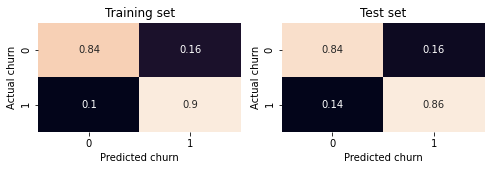

In [51]:
#Let us select the best estimator
rf2_best = model_cv_rf2.best_estimator_
print("\n Best Estimator:",rf2_best)
rf2_best.fit(X_train, y_train)

#PREDICT Churn rate
y_train_pred = rf2_best.predict(X_train)
y_test_pred = rf2_best.predict(X_test)

model_evaluation_plot(y_train,y_train_pred,y_test,y_test_pred)

**Observations:** 
-  As evident from above, RandomForest without PCA is giving the best results as compared to all the models with PCA. It may be because of below shortcomings of PCA technique - 
   - PCA produces the components to be perpendicular/orthogonal/uncorrelated, though in some cases, that may not be the best solution. The alternative technique is to use Independent Components Analysis. 
   - PCA assumes that columns with low variance are not useful, which might not be true in prediction setups (especially classification problem with a high class imbalance).

## 5.6 Key Features for Churn Indicators 

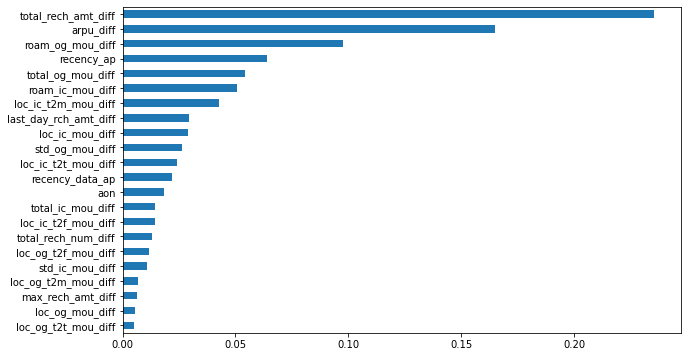

In [52]:
keyfeatures = X_train.columns.tolist()
importance = rf2_best.feature_importances_
rf_coefs = pd.Series(importance,index=keyfeatures)

plt.figure(figsize=(10,6))
rf_coefs[(rf_coefs>0.005)].sort_values().plot.barh()
plt.show()

# **<font color='blue'>6. Analysis & Business Recommendations </font>**

- The prediction model gives more importance for the reduction of `Type II Error` (missing to identify potential churn behaviour) because loosing high value customers can cause significant decline in the company revenue. 
- Although `Type I Error` (incorrectly identifing non-churn behaviour as churn) is relatively high, giving competitive offers to them will help company in longer run to generate more revenue as current focus is only on high value customers.

Below are the important churn indicator features and actionable recommendation based on the prediction model derived:

- A sudden reduction in total recharge amount(`total_rech_amnt_x`) or average revenue per user(`arpu_x`) generated from the user indicates a tendency of churn. This might be due to unsatisfactory service quality or attractive offer from competitors;as a result customer feedback needs to be collected and competitive offers need to be given based on customer value.


- An increased usage of roaming service(`roam_og_mou_x`, `roam_ic_mou_x`) leads to higher churn rate. This can be due to higher roaming charges and proposing attractive roaming packages to these customers may reduce churn.


- The derived recharge recency feature for voice and data (`recency_ap_x`, `recency_data_ap_x`) shows that customers are likely to churn if they do not charge for a period of `30-40 days`. The recharge recency of customers needs to be regularly monitored and customer needs to be approached to get/understand feedback and concerns.


- Old customers are less likely to churn since they have developed trust with the service provider. New customers with `Age on the network (`aon`)less than 2 years` are more likely to churn and offering these customers attractive packages during the initial months will develop loyalty and ensure they continue with the service. 


- If there is a reduction in minutes of usage (incoming/outgoing calls in total/std/local for onnet/offnet), the customer shows a tendency of churn - as a result the minutes of usage must be tracked regularly. 
    (`total_og_mou_x, total_ic_mou_x, loc_ic_mou_x, loc_ic_t2m_mou_x, std_og_mou_x, std_ic_mou_x ....`)